In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
# define the path where my modules are saved
module_path = 'home/m/m300909/clear sky feedback/'
# add this path tho the system path using the `sys` module
if not module_path in sys.path: sys.path.append(module_path)
# load them as they were regular python packages.
# (the file is called home/m/m300909/py_data_handling.py)
import cir_func as fun
import basic_func as bf
import inversion_func as ivf
import rad_func as rf

# Radiative cooling

## Control scenario

In [3]:
path = '/work/mh0066/m300909/mpiesm-landveg/mpiesm-landveg-3D/experiments/'
sst = ''
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs_{sst}rotation_'
experiment = ['003125x', '00625x', '1x']
experiment = ['00625x', '1x']
output_dir = '/newdata/'
model = '_echam6'
file_type = ['_tdiag','_ATM', '_mastrfu']
time = '_1976_2015'
suffix = '.nc'

file_name = [
    f"{setup}{exp}{model}{file_type[0]}{time}{suffix}" for exp in experiment
]

In [4]:
ctrl_rad = {}

rotation = ['1/32', '1/16', '1']
rotation = ['1/16', '1']

for i, rot in enumerate(rotation):
    ctrl_rad[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

In [5]:
file_name = [
    f"{setup}{exp}{model}{file_type[1]}{time}{suffix}" for exp in experiment
]

ctrl_ATM = {}

for i, rot in enumerate(rotation):
    ctrl_ATM[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

In [6]:
file_name = [
    f"{setup}{exp}{model}{file_type[2]}{time}{suffix}" for exp in experiment
]

ctrl_mastrfu = {}

for i, rot in enumerate(rotation):
    ctrl_mastrfu[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

## Gradient

In [7]:
def subsidence_mask(omega, plev=None, hadley=None):
    """
    Create a subsidence mask for the given omega dataset.

    Parameters:
    - omega: xarray DataArray containing the omega data.
    - plev: Pressure level to select from the omega data.
    - hadley: Latitude range for the Hadley cell to select.

    Returns:
    - A boolean mask where True indicates subsidence (omega > 0).
    """
    # Initialize an empty dictionary for selection criteria
    selection_criteria = {}

    # Add pressure level to selection criteria if specified
    if plev is not None:
        selection_criteria['plev'] = plev

    # Add latitude range to selection criteria if specified
    if hadley is not None:
        selection_criteria['lat'] = slice(hadley, -hadley)

    # Apply selection criteria to omega
    omega = omega.sel(**selection_criteria)
    
    # Return a boolean mask indicating subsidence
    return omega > 0

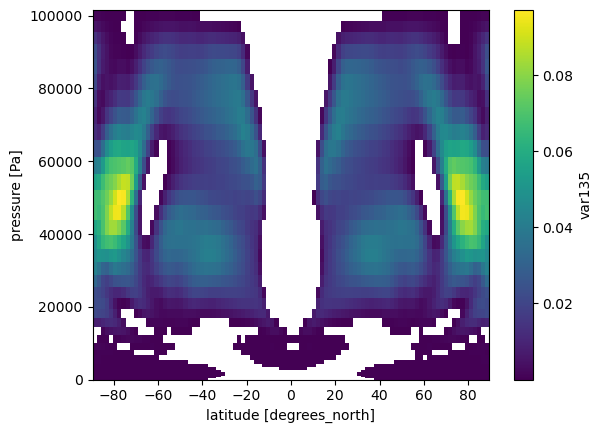

In [8]:
omega = ctrl_ATM['1/16']['var135'].mean(dim=['time'])
omega_subsidence = subsidence_mask(omega)
omega_subsidence = omega.where(omega_subsidence, drop=True)
omega_subsidence.mean(dim=['lon']).plot()

In [9]:
congestus = {}
cm = plt.cm.Blues(np.linspace(0, 1, 6))
color_map = {'1': 'grey'}

for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(ctrl_rad.items(), ctrl_ATM.items())):
    q_rad = (variable_rad['dtdt_rheat_lw'] + variable_rad['dtdt_rheat_sw']).mean(dim='time')
    omega = variable_ATM['var135'].mean(dim='time')
    
    dq_dp = (q_rad * -1).differentiate('plev') * 100
    
    subsidence = subsidence_mask(omega, plev=None)
    dq_dp_subsidence = dq_dp.where(subsidence, drop=True)
    q_subsidence = q_rad.where(subsidence, drop=True)

    dq_dp_mean_subsidence = bf.global_mean_weighted(dq_dp_subsidence)
    q_mean_subsidence = bf.global_mean_weighted(q_subsidence)

    # Ensure the key exists in the dictionary
    if key_rad not in congestus:
        congestus[key_rad] = {}

    # Use the correct key for color mapping
    color = color_map.get(key_rad, cm[i+2])
        
    congestus[key_rad]['rad_cool'] = {
        'dq_dp': dq_dp_mean_subsidence, 
        'q_rad': q_mean_subsidence,
        'color': color
    }

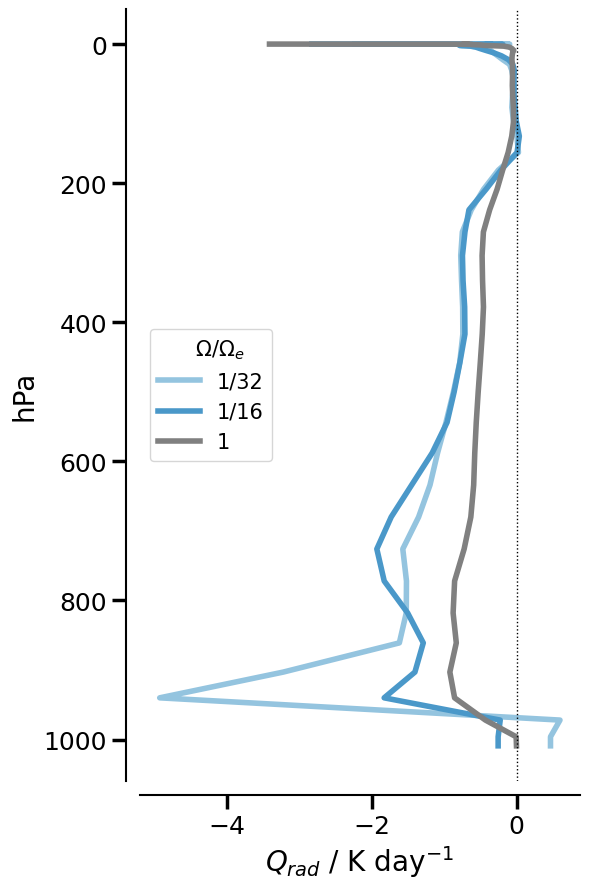

In [10]:
xlabel = r'$\frac{\partial Q_{rad}}{\partial p}$ / K day$^{-1}$ hPa$^{-1}$'
xlabel = r'$Q_{rad}$ / K day$^{-1}$'
ylabel = 'hPa'
#xlim = [-0.015, 0.015]

fig,ax = plt.subplots(figsize=(6,9))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    

for key, var in congestus.items():
    
    var_name = congestus[key]['rad_cool']['q_rad']
    color = congestus[key]['rad_cool']['color']
    
    ax.plot(var_name, var_name.plev/100, color = color, label = key, linewidth = 4)        

ax.xaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
#ax.set_xlim(xlim)
ax.axvline(x=0, color='k', linewidth=1, linestyle='dotted')
plt.xlabel(xlabel, size=20)
plt.ylabel(ylabel, size=20)
plt.legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=15, fontsize=15)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('Figures/q_rad_dp.pdf')

# Relative humidity and clouds

In [11]:
cm1 = plt.cm.Greens(np.linspace(0, 1, 6))
cm2 = plt.cm.Purples(np.linspace(0, 1, 6))
color_map = {'1': 'grey'}

for i, (key, variable) in enumerate(ctrl_ATM.items()):
    
    rh = variable['relhum'].mean(dim='time')
    cloud = variable['aclcac'].mean(dim='time')
    cloud_water = variable['q'].mean(dim='time')
    cloud_water = cloud_water.differentiate('plev') * 100
    w = variable['var135'].mean(dim='time')
    
    w_subsidence = subsidence_mask(w)
    rh_subsidence = rh.where(w_subsidence, drop=True)
    rh_subsidence = bf.global_mean_weighted(rh_subsidence)

    cloud_subsidence = cloud.where(w_subsidence, drop=True)
    cloud_subsidence = bf.global_mean_weighted(cloud_subsidence)
    cloud_water_subsidence = cloud_water.where(w_subsidence, drop=True)
    cloud_water_subsidence = bf.global_mean_weighted(cloud_water_subsidence)
    
    color1 = color_map.get(key, cm1[i+2])
    color2 = color_map.get(key, cm2[i+2])

    congestus[key]['relhum'] = {'rh_descent': rh_subsidence, 'color': color1}
    congestus[key]['cloud'] = {'cloud_descent': cloud_subsidence, 'cloud_water': cloud_water_subsidence,
                               'color': color2}

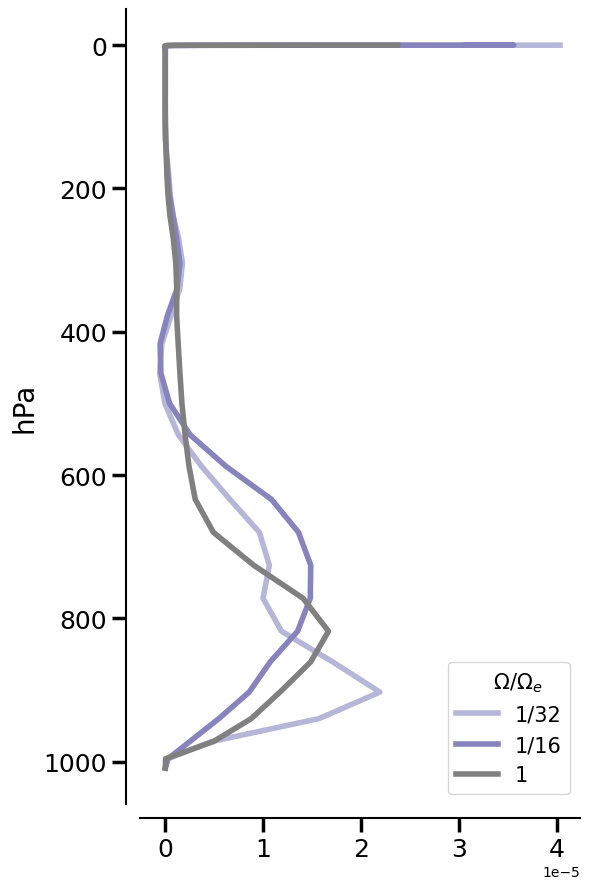

In [12]:
xlabel = ''
ylabel = 'hPa'
xlim = [-0.5e-6, 0.5e-6]

fig,ax = plt.subplots(figsize=(6,9))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    

for key, var in congestus.items():
    
    var_name = congestus[key]['cloud']['cloud_water']
    color = congestus[key]['cloud']['color']
    
    ax.plot(var_name, var_name.plev/100, color = color, label = key, linewidth = 4)
    
ax.xaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
#ax.set_xlim(xlim)
#ax.axvline(x=0, color='k', linewidth=1, linestyle='dotted')
plt.xlabel(xlabel, size=20)
plt.ylabel(ylabel, size=20)
plt.legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=15, fontsize=15)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('Figures/rh.pdf')

# Vertical wind

In [13]:
# Define color map and specific color mapping
cm = plt.cm.Reds(np.linspace(0, 1, 6))
color_map = {'1': 'grey'}

for i, (key, variable) in enumerate(ctrl_ATM.items()):
    w = variable['var135'].mean(dim=['time'])
    
    w_subsidence = subsidence_mask(w)
    w_subsidence = w.where(w_subsidence, drop=True)
    w_subsidence = bf.global_mean_weighted(w_subsidence)

    # Use the color map to get the color, defaulting to the colormap if not specified
    color = color_map.get(key, cm[i+2])
    
    # Populate the dictionaries
    congestus[key]['omega'] = {'omega_descent': w_subsidence, 'color': color}

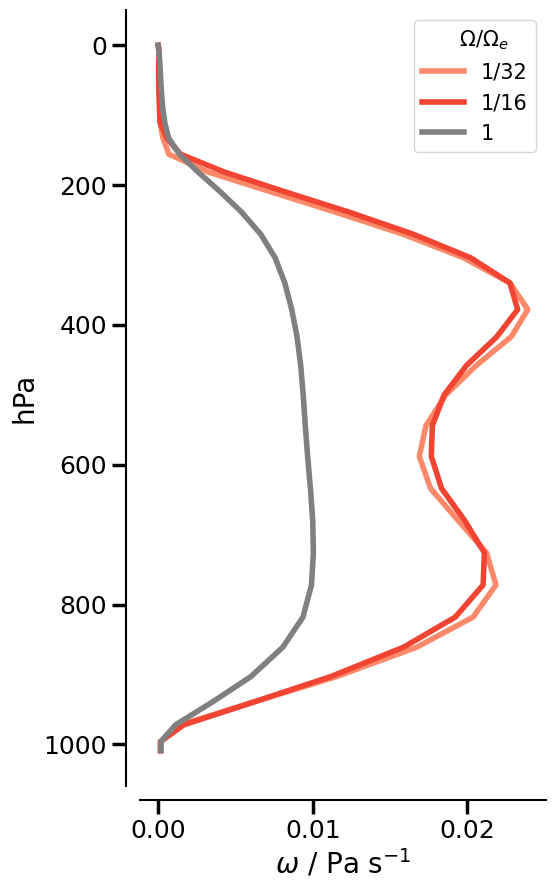

In [14]:
xlabel = r'$\omega$ / Pa s$^{-1}$'
#xlabel = r'$\frac{\partial \omega}{\partial p}$ / d$^{-1}$'
ylabel = 'hPa'
xlim = [0, 0.05]

fig,ax = plt.subplots(figsize=(6,9))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    

for key, var in congestus.items():
    
    var_name = congestus[key]['omega']['omega_descent']
    color = congestus[key]['omega']['color']
    
    ax.plot(var_name, var_name.plev/100, color = color, label = key, linewidth = 4)

ax.xaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
#ax.set_xlim(xlim)
#ax.axvline(x=0, color='k', linewidth=1, linestyle='dotted')
plt.xlabel(xlabel, size=20)
plt.ylabel(ylabel, size=20)
plt.legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=15, fontsize=15)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('Figures/omega.pdf')

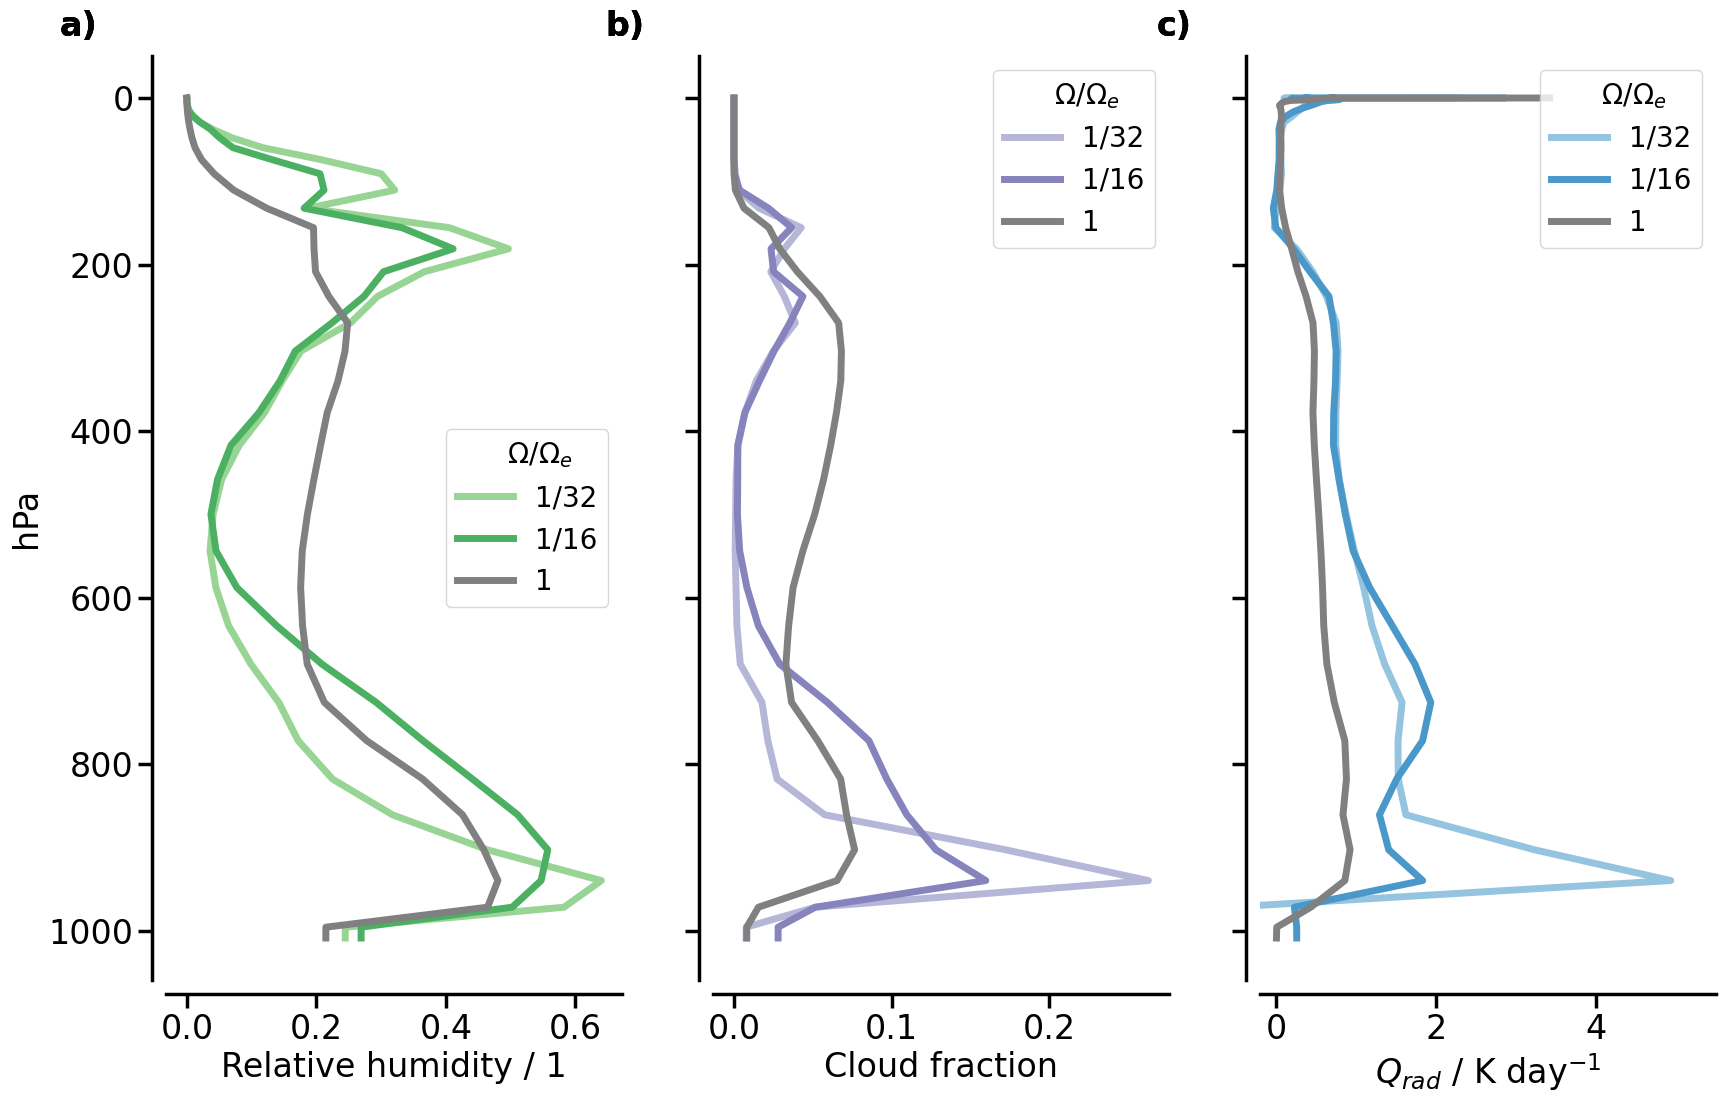

In [15]:
# Function to configure axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 12), sharey='row')
axes = axes.ravel()

def configure_axes(ax, xlabel, xlim=None, ylabel=False):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_xlabel(xlabel, fontsize=24)
    ax.xaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    if ylabel:
        #ax.invert_yaxis()  # Ensure this is called before plotting
        ax.set_ylabel('hPa', size=24)
    if xlim:
        ax.set_xlim(xlim)

subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)']
# Iterate over axes
for key, var in congestus.items():
    for i, ax in enumerate(axes):

        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')
        
        if i == 0:
            var_name = var['relhum']['rh_descent']
            color = var['relhum']['color']
            xlabel = 'Relative humidity / 1'
            configure_axes(ax, xlabel, ylabel=True)
        elif i == 1:
            var_name = var['cloud']['cloud_descent']
            color = var['cloud']['color']
            xlabel = 'Cloud fraction'
            configure_axes(ax, xlabel)
        elif i == 2:
            var_name = -1 * var['rad_cool']['q_rad']
            color = var['rad_cool']['color']
            xlabel = r'$Q_{rad}$ / K day$^{-1}$'
            xlim = [-0.2, 5.5]
            configure_axes(ax, xlabel, xlim=xlim)
        #elif i == 3:
            #var_name = var['omega']['omega_descent']
            #color = var['omega']['color']
            #xlabel = r'$\omega_{output}$ / Pa s$^{-1}$'
            #xlim = [None, 0.027]
            #configure_axes(ax, xlabel, xlim=xlim)#, invert_y=True)
        #elif i == 4:
            #var_name = var['diagnosis']['omega']
            #color = var['diagnosis']['color']
            #xlabel = r'$\omega_{rad}$ / Pa s$^{-1}$'
            #xlim = [None, 0.03]
            #configure_axes(ax, xlabel, xlim=xlim)
        
        ax.plot(var_name, var_name.plev / 100, color=color, label=key, linewidth=5)
ax.invert_yaxis()
# Add legends after plotting
axes[0].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='center right')
axes[1].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
axes[2].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[3].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')

plt.savefig('Figures/congestus_fig_a.pdf')

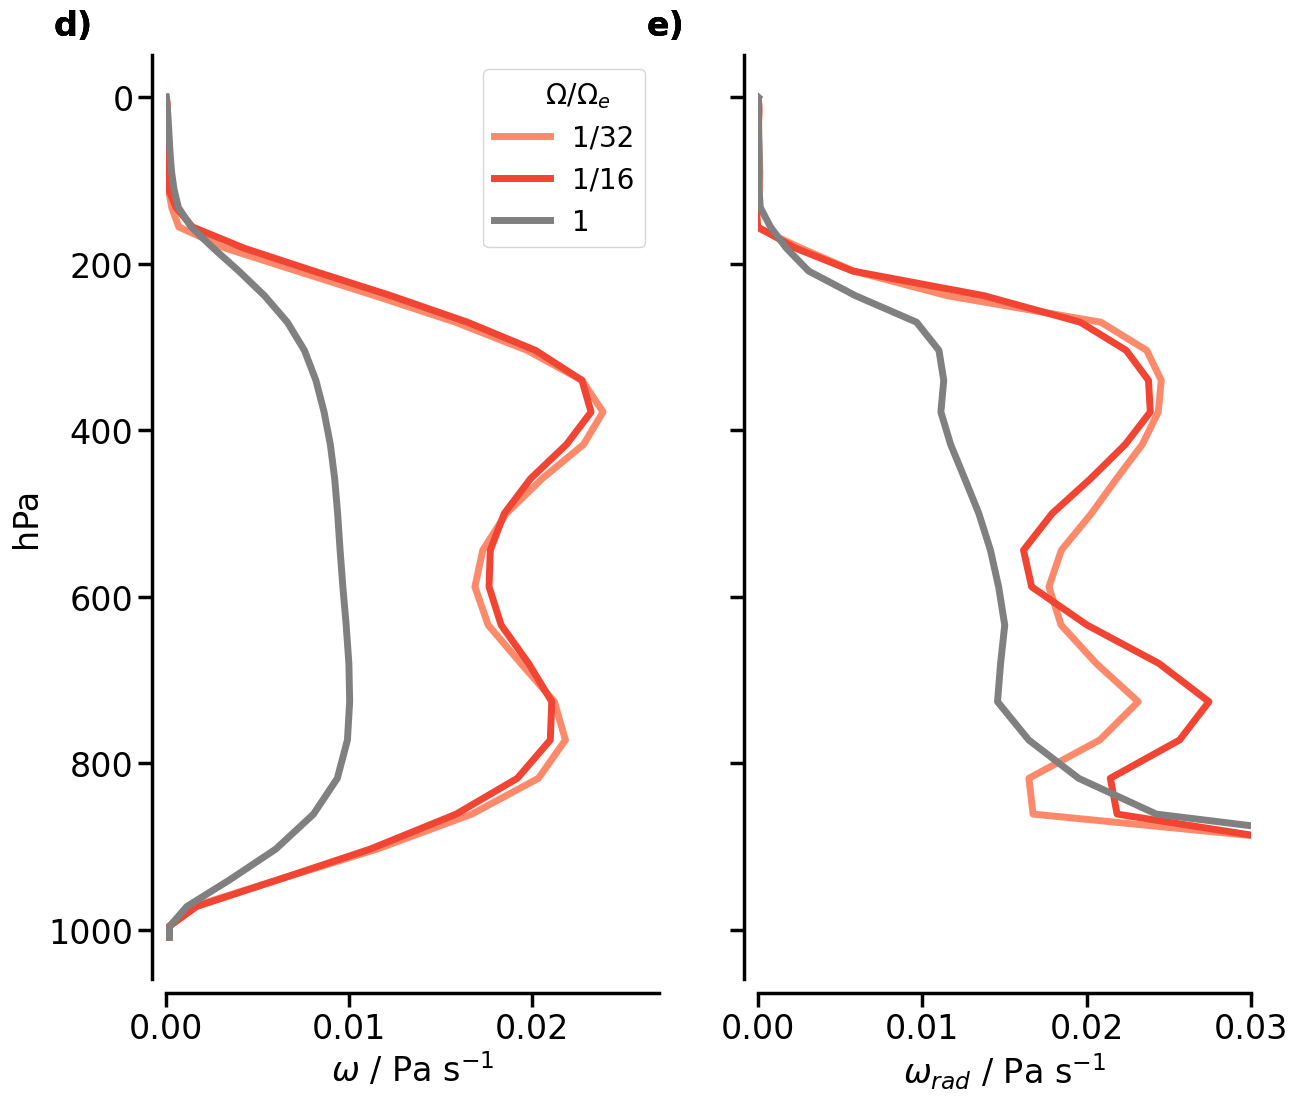

In [17]:
# Function to configure axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 12), sharey='row')
axes = axes.ravel()

def configure_axes(ax, xlabel, xlim=None, ylabel=False):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_xlabel(xlabel, fontsize=24)
    ax.xaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    if ylabel:
        #ax.invert_yaxis()  # Ensure this is called before plotting
        ax.set_ylabel('hPa', size=24)
    if xlim:
        ax.set_xlim(xlim)

subplot_labels = [ 'd)', 'e)']
# Iterate over axes
for key, var in congestus.items():
    for i, ax in enumerate(axes):

        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')
        
        if i == 0:
            var_name = var['omega']['omega_descent']
            color = var['omega']['color']
            xlabel = r'$\omega$ / Pa s$^{-1}$'
            xlim = [None, 0.027]
            configure_axes(ax, xlabel, xlim=xlim, ylabel=True)#, invert_y=True)

        elif i == 1:
            var_name = var['diagnosis']['omega']
            color = var['diagnosis']['color']
            xlabel = r'$\omega_{rad}$ / Pa s$^{-1}$'
            xlim = [None, 0.03]
            configure_axes(ax, xlabel, xlim=xlim)
        
        ax.plot(var_name, var_name.plev / 100, color=color, label=key, linewidth=5)
ax.invert_yaxis()
# Add legends after plotting
axes[0].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')

plt.savefig('Figures/congestus_fig_b.pdf')

# Diagnosis of Divergence

In [16]:
cm = plt.cm.Reds(np.linspace(0, 1, 6))
color_map = {'1': 'grey'}

for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(ctrl_rad.items(), ctrl_ATM.items())):

    q_rad = (variable_rad['dtdt_rheat_lw'] + variable_rad['dtdt_rheat_sw'])
    q_cloud = variable_rad['dtdt_cloud']
    q_con = variable_rad['dtdt_cucall']
    st = variable_ATM['st']
    tpot = variable_ATM['tpot']
    stability = bf.static_stability(st)
    stability = -(st / tpot) * tpot.differentiate('plev')
    w = variable_ATM['var135'].mean(dim='time')

    q = -1 * (q_rad)/ (24 * 3600)
    omega = q/stability

    q_all = -1 * (q_rad + q_cloud + q_con)
    omega_all = q_all/(stability * (24 * 3600))

    #domega_dp = omega.differentiate('plev')    
    
    w_subsidence = subsidence_mask(w)
    omega = omega.where(w_subsidence, drop=True)
    omega = bf.global_mean_weighted(omega)

    omega_all = omega_all.where(w_subsidence, drop=True)
    omega_all = bf.global_mean_weighted(omega_all)

    q_all = q_all.where(w_subsidence, drop=True)
    q_all = bf.global_mean_weighted(q_all)

    color = color_map.get(key_rad, cm[i+2])
        
    congestus[key_rad]['diagnosis'] = {'omega': omega,
                                       'q_all': q_all,
                                       'omega_all': omega_all,
                                       'color': color}
 

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/n

In [26]:
cm = plt.cm.Blues(np.linspace(0, 1, 7))
color_map = {'1': 'grey'}

for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(ctrl_rad.items(), ctrl_ATM.items())):
    q_rad = (variable_rad['dtdt_rheat_lw'] + variable_rad['dtdt_rheat_sw'])
    q_cloud = variable_rad['dtdt_cloud']
    q_con = variable_rad['dtdt_cucall']
    omega = variable_ATM['var135'].mean(dim='time')

    q = q_rad + q_cloud + q_con
    
    subsidence = subsidence_mask(omega, plev=None)
    q_subsidence = q.where(subsidence, drop=True)

    q_subsidence = bf.global_mean_weighted(q_subsidence)

    # Use the correct key for color mapping
    color = color_map.get(key_rad, cm[i+2])
        
    congestus[key_rad]['cooling'] = {
        'q': q_subsidence,
        'color': color
    }

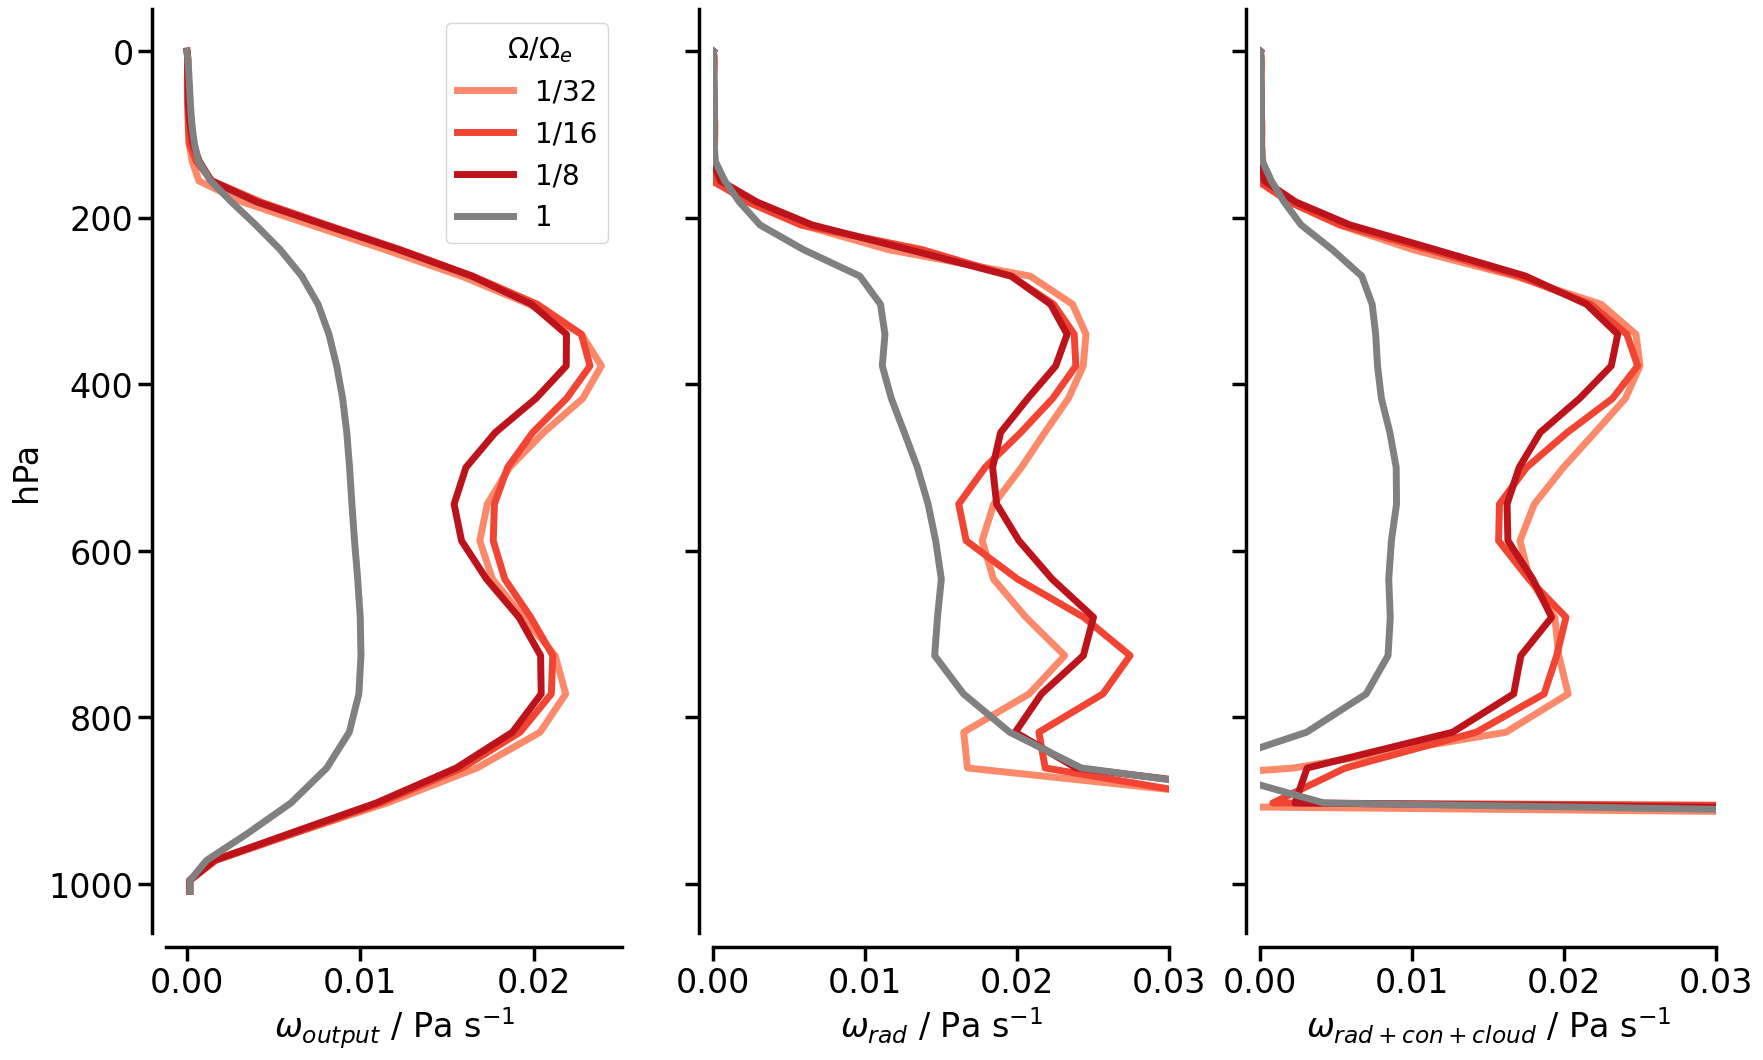

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 12), sharey='row')
axes = axes.ravel()

# Function to configure axes
def configure_axes(ax, xlabel, ylabel=False, xlim=None):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_xlabel(xlabel, fontsize=24)
    ax.xaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    if  ylabel:
        #ax.invert_yaxis()
        ax.set_ylabel('hPa', size=24)
    if xlim:
        ax.set_xlim(xlim)

# Iterate over axes
for key, var in congestus.items():
    for i, ax in enumerate(axes):
        if i == 1:
            var_name = var['diagnosis']['omega']
            color = var['diagnosis']['color']
            xlabel = r'$\omega_{rad}$ / Pa s$^{-1}$'
            xlim = [0, 0.03]
            configure_axes(ax, xlabel,xlim=xlim)
        elif i == 0:
            var_name = var['omega']['omega_descent']
            color = var['omega']['color']
            xlabel = r'$\omega_{output}$ / Pa s$^{-1}$'
            configure_axes(ax, xlabel, ylabel=True)
        elif i == 2:
            var_name = var['diagnosis']['omega_all']
            color = var['diagnosis']['color']
            xlabel = r'$\omega_{rad + con + cloud}$ / Pa s$^{-1}$'
            xlim = [0, 0.03]
            configure_axes(ax, xlabel, xlim=xlim)
        
        ax.plot(var_name, var_name.plev / 100, color=color, label=key, linewidth=5)
ax.invert_yaxis()
# Add legends after plotting
axes[0].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[1].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[2].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[3].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')

plt.savefig('Figures/congestus_fig.pdf')

# Radiative cooling response

## Warming scenario

### 1K

In [8]:
sst = '_1K'
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs{sst}_rotation_'

file_name = [
    f"{setup}{exp}{model}{file_type[0]}{time}{suffix}" for exp in experiment
]

warm_1K_rad = {}

for i, rot in enumerate(rotation):
    warm_1K_rad[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

file_name = [
    f"{setup}{exp}{model}{file_type[1]}{time}{suffix}" for exp in experiment
]

warm_1K_atm = {}

for i, rot in enumerate(rotation):
    warm_1K_atm[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

file_name = [
    f"{setup}{exp}{model}{file_type[2]}{time}{suffix}" for exp in experiment
]

warm_1K_mastrfu = {}

for i, rot in enumerate(rotation):
    warm_1K_mastrfu[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

### 2K

In [9]:
sst = '_2K'
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs{sst}_rotation_'

file_name = [
    f"{setup}{exp}{model}{file_type[0]}{time}{suffix}" for exp in experiment
]

warm_2K_rad = {}

for i, rot in enumerate(rotation):
    warm_2K_rad[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

file_name = [
    f"{setup}{exp}{model}{file_type[1]}{time}{suffix}" for exp in experiment
]

warm_2K_atm = {}

for i, rot in enumerate(rotation):
    warm_2K_atm[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

file_name = [
    f"{setup}{exp}{model}{file_type[2]}{time}{suffix}" for exp in experiment
]

warm_2K_mastrfu = {}

for i, rot in enumerate(rotation):
    warm_2K_mastrfu[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

### 3K

In [10]:
sst = '_3K'
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs{sst}_rotation_'

file_name = [
    f"{setup}{exp}{model}{file_type[0]}{time}{suffix}" for exp in experiment
]

warm_3K_rad = {}

for i, rot in enumerate(rotation):
    warm_3K_rad[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

file_name = [
    f"{setup}{exp}{model}{file_type[1]}{time}{suffix}" for exp in experiment
]

warm_3K_atm = {}

for i, rot in enumerate(rotation):
    warm_3K_atm[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

file_name = [
    f"{setup}{exp}{model}{file_type[2]}{time}{suffix}" for exp in experiment
]

warm_3K_mastrfu = {}

for i, rot in enumerate(rotation):
    warm_3K_mastrfu[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

### 4K

In [11]:
sst = '_4K'
ensemble = f'fixed_SST{sst}/'
setup = f'aquaplanet_Qobs{sst}_rotation_'

file_name = [
    f"{setup}{exp}{model}{file_type[0]}{time}{suffix}" for exp in experiment
]

warm_4K_rad = {}

for i, rot in enumerate(rotation):
    warm_4K_rad[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

file_name = [
    f"{setup}{exp}{model}{file_type[1]}{time}{suffix}" for exp in experiment
]

warm_4K_atm = {}

for i, rot in enumerate(rotation):
    warm_4K_atm[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

file_name = [
    f"{setup}{exp}{model}{file_type[2]}{time}{suffix}" for exp in experiment
]

warm_4K_mastrfu = {}

for i, rot in enumerate(rotation):
    warm_4K_mastrfu[rot] = xr.open_dataset(
        path + ensemble + setup + experiment[i] + output_dir + file_name[i],
        decode_times='true'
    )

In [12]:
data_rad = {
    'ctrl': ctrl_rad, 
    '1K': warm_1K_rad,
    '2K': warm_2K_rad,
    '3K': warm_3K_rad,
    '4K': warm_4K_rad
}

In [13]:
data_ATM = {
    'ctrl': ctrl_ATM, 
    '1K': warm_1K_atm,
    '2K': warm_2K_atm,
    '3K': warm_3K_atm,
    '4K': warm_4K_atm
}

In [14]:
data_mastrfu = {
    'ctrl': ctrl_mastrfu, 
    '1K': warm_1K_mastrfu,
    '2K': warm_2K_mastrfu,
    '3K': warm_3K_mastrfu,
    '4K': warm_4K_mastrfu
}

In [15]:
congestus = {}
cm = plt.cm.Blues(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):
    q_rad = variable_rad['1/16']['dtdt_rheat_lw'] + variable_rad['1/16']['dtdt_rheat_sw']#.mean(dim='time')
    q_cloud = variable_rad['1/16']['dtdt_cloud']
    q_con = variable_rad['1/16']['dtdt_cucall']
    omega = variable_ATM['1/16']['var135'].mean(dim='time')

    q = -1 * (q_rad + q_cloud + q_con)
    q = q.mean(dim='time')
    q_rad = q_rad.mean(dim='time')
    
    subsidence = bf.subsidence_mask(omega, plev=None)
    q_subsidence = q.where(subsidence, drop=True)
    q_rad_subsidence = q_rad.where(subsidence, drop=True)

    q_rad_mean_subsidence = bf.global_mean_weighted(q_rad_subsidence)
    q_mean_subsidence = bf.global_mean_weighted(q_subsidence)

    # Ensure the key exists in the dictionary
    if key_rad not in congestus:
        congestus[key_rad] = {}

    # Use the correct key for color mapping
    color = color_map.get(key_rad, cm[i+1])
        
    congestus[key_rad]['cooling 1/16'] = {
        'q': q_mean_subsidence, 
        'q_rad': q_rad_mean_subsidence,
        'color': color
    }

In [35]:
cm = plt.cm.Blues(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):
    q_rad = variable_rad['1/32']['dtdt_rheat_lw'] + variable_rad['1/32']['dtdt_rheat_sw']#.mean(dim='time')
    q_cloud = variable_rad['1/32']['dtdt_cloud']
    q_con = variable_rad['1/32']['dtdt_cucall']
    omega = variable_ATM['1/32']['var135'].mean(dim='time')

    q = -1 * (q_rad + q_cloud + q_con)
    q = q.mean(dim='time')
    q_rad = q_rad.mean(dim='time')
    
    subsidence = bf.subsidence_mask(omega, plev=None)
    q_subsidence = q.where(subsidence, drop=True)
    q_rad_subsidence = q_rad.where(subsidence, drop=True)

    q_rad_mean_subsidence = bf.global_mean_weighted(q_rad_subsidence)
    q_mean_subsidence = bf.global_mean_weighted(q_subsidence)

    # Use the correct key for color mapping
    color = color_map.get(key_rad, cm[i+1])
        
    congestus[key_rad]['cooling 1/32'] = {
        'q': q_mean_subsidence, 
        'q_rad': q_rad_mean_subsidence,
        'color': color
    }

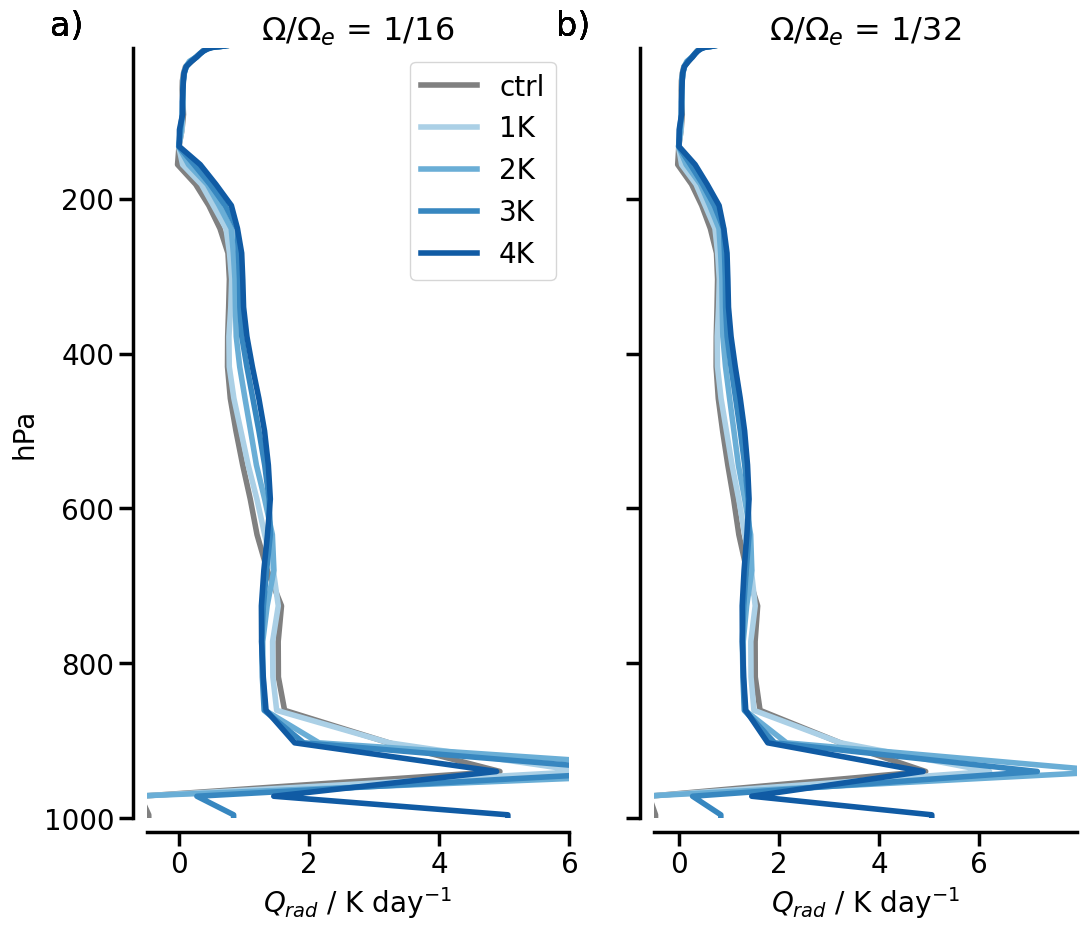

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 10), sharey='row')
axes = axes.ravel()

# Function to configure axes
def configure_axes(ax, xlabel, ylabel=False, xlim=None, title=None):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_xlabel(xlabel, fontsize=20)
    ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
    if  ylabel:
        #ax.invert_yaxis()
        ax.set_ylabel('hPa', size=20)
    if xlim:
        ax.set_xlim(xlim)
    if title:
        ax.set_title(title, size=23)

subplot_labels = ['a)', 'b)', 'c)']

# Iterate over axes
for key, var in congestus.items():
    for i, ax in enumerate(axes):
        
        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, va='top', ha='right')
        
        if i == 0:
            var_name = -1 * var['cooling 1/16']['q_rad']
            color = var['cooling 1/16']['color']
            xlabel = r'$Q_{rad}$ / K day$^{-1}$'
            xlim = [-0.5,6]
            configure_axes(ax, xlabel,ylabel=True, xlim=xlim,title=r'$\Omega/\Omega_e$ = 1/16')
        elif i == 1:
            var_name = -1 * var['cooling 1/32']['q_rad']
            color = var['cooling 1/32']['color']
            xlabel = r'$Q_{rad}$ / K day$^{-1}$'
            xlim = [-0.5,7.95]
            configure_axes(ax, xlabel, xlim=xlim,title=r'$\Omega/\Omega_e$ = 1/32')
        
        ax.plot(var_name, var_name.plev / 100, color=color, label=key, linewidth=4)
        
ax.invert_yaxis()
ax.set_ylim(1000,5)
# Add legends after plotting
axes[0].legend( title_fontsize=20, fontsize=20, loc='upper right')
#axes[1].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[2].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[3].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')

plt.savefig('Figures/q_rad.pdf')

In [47]:
cm = plt.cm.Purples(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):
    cloud = variable_ATM['1/32']['aclcac']
    omega = variable_ATM['1/32']['var135'].mean(dim='time')

    low_cloud = cloud.sel(plev=slice(100000, 70000)).mean(dim=['time','lon','plev'])
    
    subsidence = bf.subsidence_mask(omega, plev=None)
    cloud_subsidence = cloud.where(subsidence, drop=True)

    cloud_mean_subsidence = bf.global_mean_weighted(cloud)

    # Use the correct key for color mapping
    color = color_map.get(key_rad, cm[i+1])
        
    congestus[key_rad]['cloud_1/32'] = {
        'cld_fraction': cloud_mean_subsidence,
        'low_cloud': low_cloud,
        'color': color
    }

In [48]:
cm = plt.cm.Purples(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):
    cloud = variable_ATM['1/16']['aclcac']
    omega = variable_ATM['1/16']['var135'].mean(dim='time')

    low_cloud = cloud.sel(plev=slice(100000, 70000)).mean(dim=['time','lon','plev'])
    
    subsidence = bf.subsidence_mask(omega, plev=None)
    cloud_subsidence = cloud.where(subsidence, drop=True)

    cloud_mean_subsidence = bf.global_mean_weighted(cloud)

    # Use the correct key for color mapping
    color = color_map.get(key_rad, cm[i+1])

    if key_rad not in congestus:
        congestus[key_rad] = {}
        
    congestus[key_rad]['cloud_1/16'] = {
        'cld_fraction': cloud_mean_subsidence,
        'low_cloud': low_cloud,
        'color': color
    }

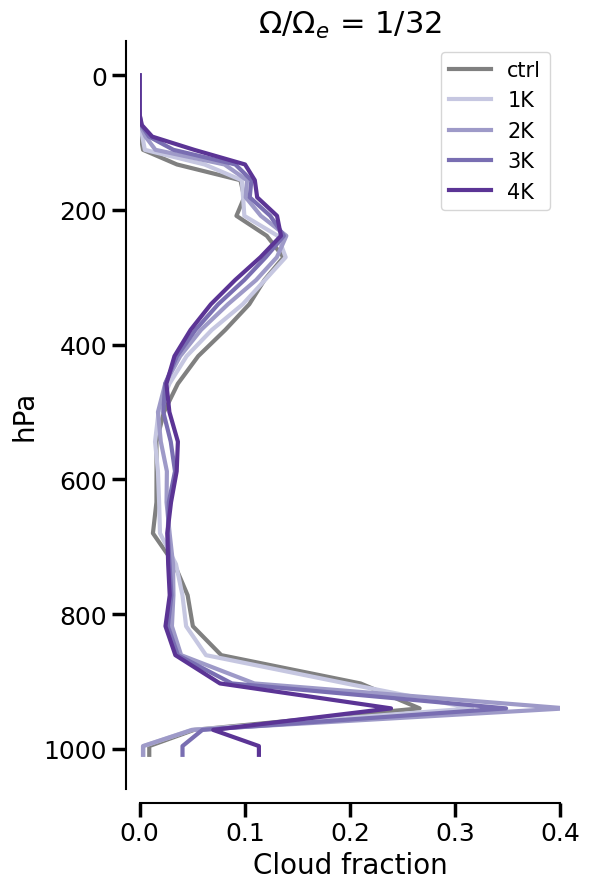

In [49]:
xlabel = 'Cloud fraction'
ylabel = 'hPa'
xlim = [-5, 0]
xlim = [0, 0.4]

fig,ax = plt.subplots(figsize=(6,9))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    

for key, var in congestus.items():
    
    var_name = congestus[key]['cloud_1/32']['cld_fraction']
    color = congestus[key]['cloud_1/32']['color']
    
    ax.plot(var_name, var_name.plev/100, color = color, label = key, linewidth = 3)        

ax.xaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
#ax.set_xticks([0, 2.5, 5.0, 7.5])
ax.set_xlim(xlim)
#ax.axvline(x=0, color='k', linewidth=1, linestyle='dotted')
plt.xlabel(xlabel, size=20)
plt.ylabel(ylabel, size=20)
plt.legend( title_fontsize=15, fontsize=15)
ax.invert_yaxis()
ax.set_title(r'$\Omega/\Omega_e$ = 1/32', size=22)

plt.tight_layout()
plt.savefig('Figures/cloud_changes.pdf')

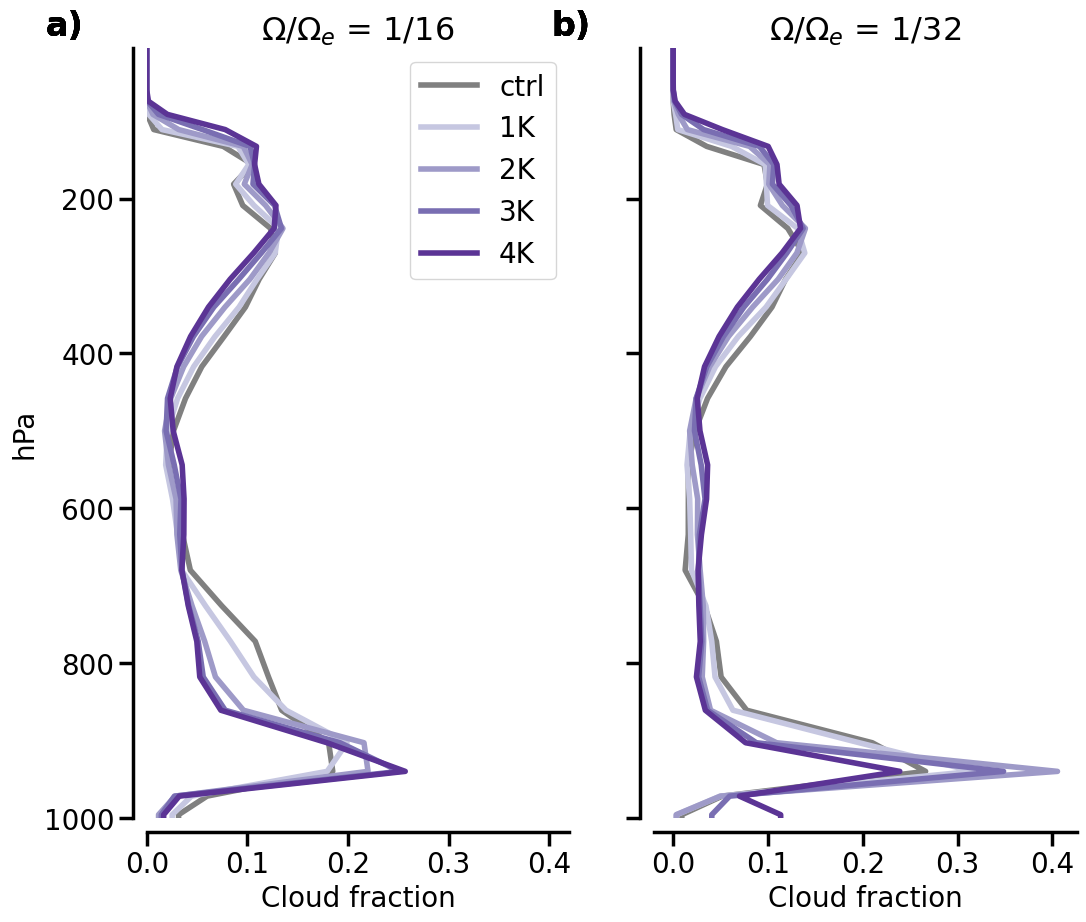

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 10), sharey='row')
axes = axes.ravel()

# Function to configure axes
def configure_axes(ax, xlabel, ylabel=False, xlim=None, title=None):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_xlabel(xlabel, fontsize=20)
    ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
    if  ylabel:
        #ax.invert_yaxis()
        ax.set_ylabel('hPa', size=20)
    if xlim:
        ax.set_xlim(xlim)
    if title:
        ax.set_title(title, size=23)

subplot_labels = ['a)', 'b)', 'c)']

# Iterate over axes
for key, var in congestus.items():
    for i, ax in enumerate(axes):
        
        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')
        
        if i == 0:
            var_name = var['cloud_1/16']['cld_fraction']
            color = var['cloud_1/16']['color']
            xlabel = 'Cloud fraction'
            xlim = [0, 0.42]
            configure_axes(ax, xlabel,ylabel=True, xlim=xlim,title=r'$\Omega/\Omega_e$ = 1/16')
        elif i == 1:
            var_name = var['cloud_1/32']['cld_fraction']
            color = var['cloud_1/32']['color']
            xlabel = 'Cloud fraction'
            configure_axes(ax, xlabel, title=r'$\Omega/\Omega_e$ = 1/32')
        
        ax.plot(var_name, var_name.plev / 100, color=color, label=key, linewidth=4)
        
ax.invert_yaxis()
ax.set_ylim(1000,5)
# Add legends after plotting
axes[0].legend( title_fontsize=20, fontsize=20, loc='upper right')
#axes[1].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[2].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[3].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')

plt.savefig('Figures/cloud.pdf')

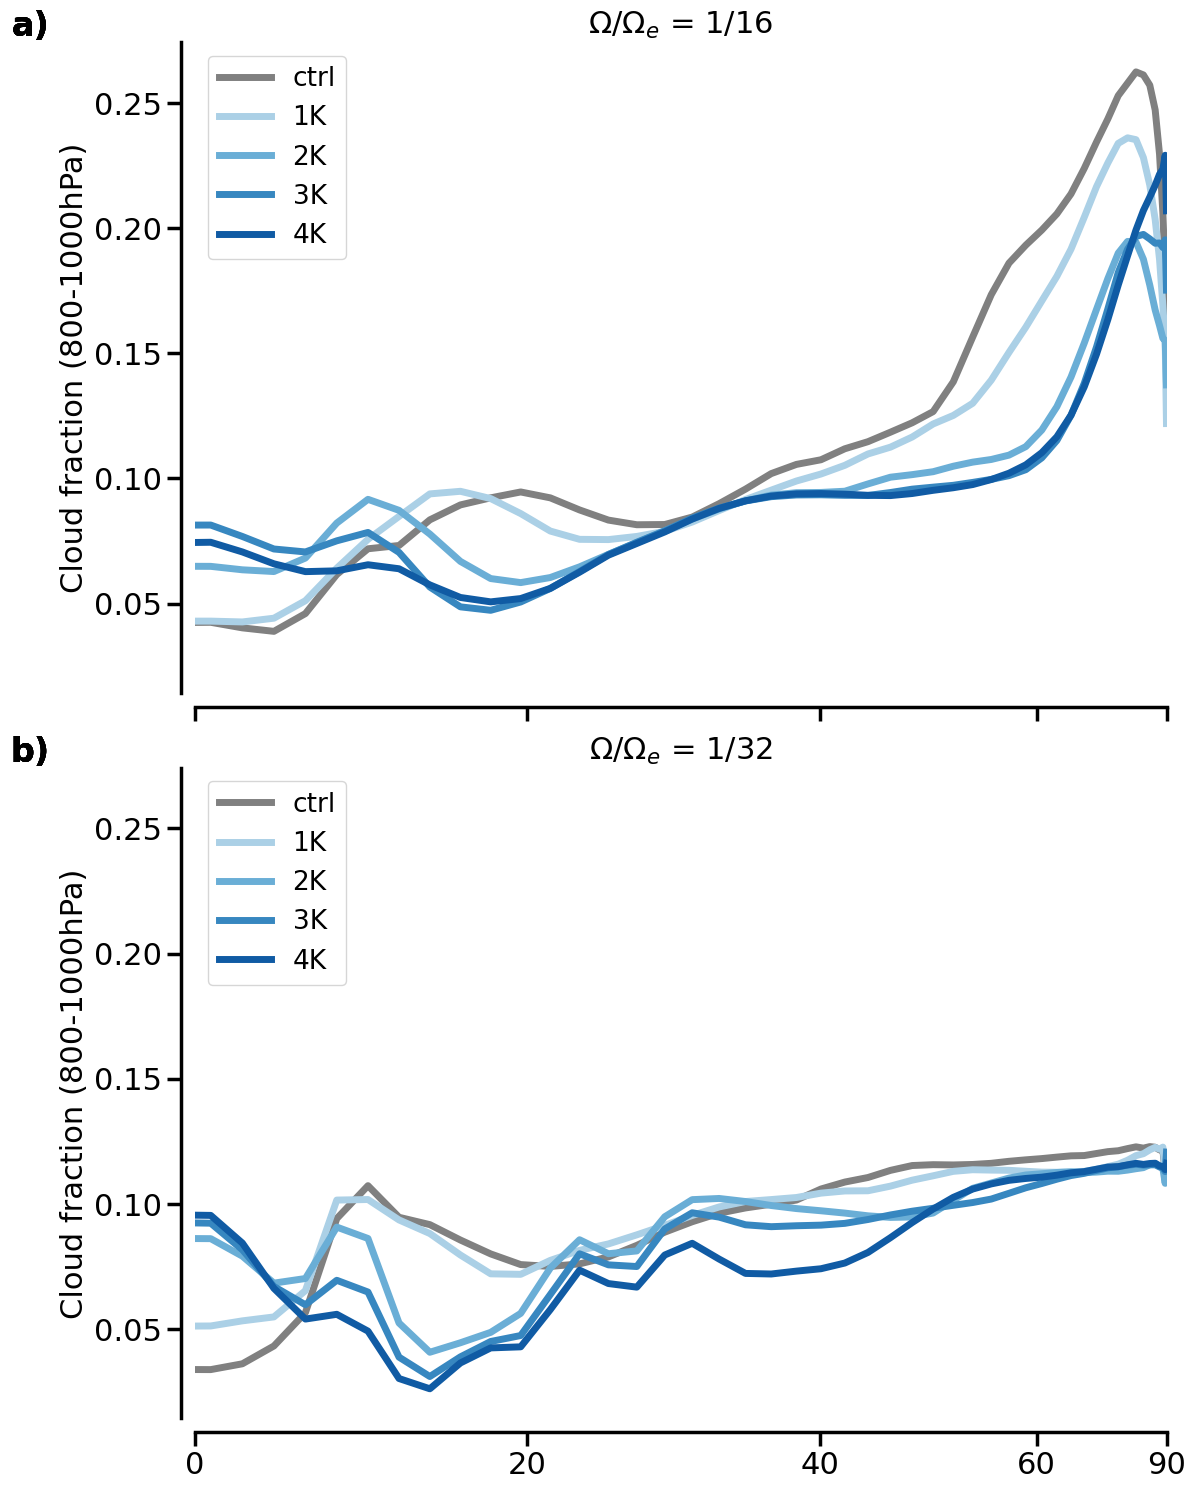

In [22]:
from matplotlib.ticker import ScalarFormatter

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 15), sharex=True, sharey='col')
axes = axes.ravel()

def configure_axes(ax, ylabel, ylim=None, xlabel=False, title=False):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_ylabel(ylabel, fontsize=22)
    ax.xaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    if xlabel:
        ax.set_xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=22)
    if ylim:
        ax.set_ylim(ylim)
    if title:
        ax.set_title(title, size=22)

# Iterate over axes
subplot_labels = ['a)', 'b)', 'c)']

for key, var in congestus.items():
    for i, ax in enumerate(axes):

        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')

        if i == 0:
            var_name = var['cloud_1/16']['low_cloud']
            color = var['cloud_1/16']['color']
            x = np.sin(np.deg2rad(var['cloud_1/16']['low_cloud'].lat))
            ylabel = 'Cloud fraction (800-1000hPa)'
            configure_axes(ax, ylabel, title=r'$\Omega/\Omega_e$ = 1/16')
        elif i == 1:
            var_name = var['cloud_1/32']['low_cloud']
            color = var['cloud_1/32']['color']
            x = np.sin(np.deg2rad(var['cloud_1/32']['low_cloud'].lat))
            ylabel = 'Cloud fraction (800-1000hPa)'
            configure_axes(ax, ylabel, title=r'$\Omega/\Omega_e$ = 1/32')

        ax.plot(x, var_name, color=color, linewidth=5, linestyle='solid', 
            label=key)

        ticks_deg = np.array([-90, -60, -40, -20, 0, 20, 40, 60, 90])
        ax.set_xticks(np.sin(np.deg2rad(ticks_deg)))
        ax.set_xticklabels(ticks_deg)
        ax.set_xlim(0, np.sin(np.deg2rad(90)))
        ax.legend(fontsize=19, loc='upper left')

plt.tight_layout()
plt.savefig('Figures/low_cloud.pdf')

In [210]:
congestus = {}
cm = plt.cm.Greens(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):
    rh = variable_ATM['1/32']['relhum']
    q = variable_ATM['1/32']['q']
    omega = variable_ATM['1/32']['var135'].mean(dim='time')

    dq_dp = q.differentiate('plev').mean(dim='time')
    
    subsidence = bf.subsidence_mask(omega, plev=None)
    rh_subsidence = rh.where(subsidence, drop=True)
    q = q.where(subsidence, drop=True)
    dq_dp = dq_dp.where(subsidence, drop=True)

    rh_mean_subsidence = bf.area_mean_weighted(rh, lat_slice=slice(30,0))
    q_mean_subsidence = bf.global_mean_weighted(q)
    dq_dp_mean_subsidence = bf.global_mean_weighted(dq_dp)

    # Ensure the key exists in the dictionary
    if key_rad not in congestus:
        congestus[key_rad] = {}

    # Use the correct key for color mapping
    color = color_map.get(key_rad, cm[i+1])
        
    congestus[key_rad]['relative humidity'] = {
        'rh': rh_mean_subsidence,
        'q': q_mean_subsidence,
        'dq_dp': dq_dp_mean_subsidence,
        'color': color
    }

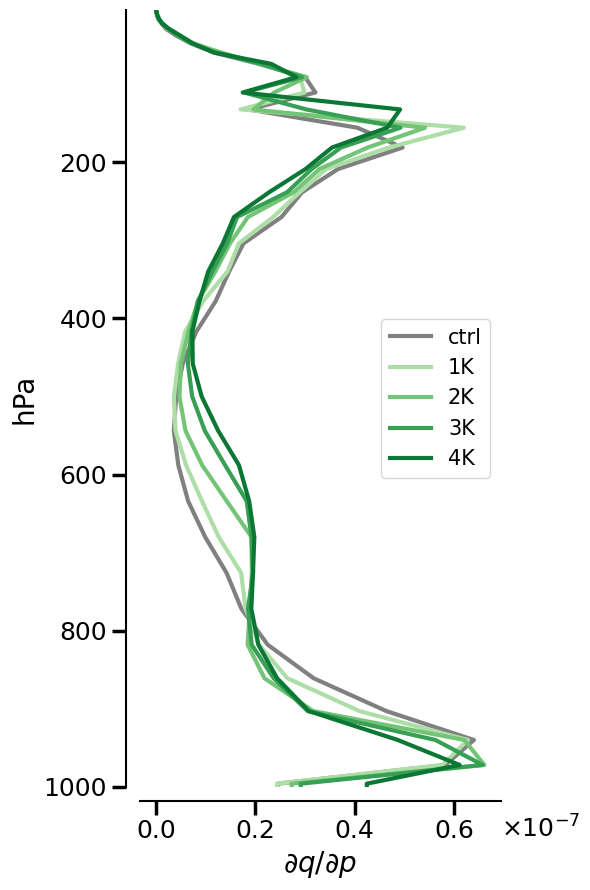

In [208]:
xlabel = 'relative humidity / 1'
xlabel = '$\partial q / \partial p$'
#xlabel = 'specific humidity / kg kg$^{-1}$'
ylabel = 'hPa'
xlim = [-10, 5]
ylim = [5, 1000]
xlim = [0, 4e-7]

fig,ax = plt.subplots(figsize=(6,9))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    

for key, var in congestus.items():
    
    var_name = congestus[key]['relative humidity']['rh']
    color = congestus[key]['relative humidity']['color']
    
    ax.plot(var_name, var_name.plev/100, color = color, label = key, linewidth = 3)        

#ax.plot(humidity, var_name.plev[:-1]/100, color = 'black', label = 'fixed RH 4K', linewidth = 3)
ax.xaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
#ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel(xlabel, size=20)
plt.ylabel(ylabel, size=20)
plt.legend( title_fontsize=15, fontsize=15)
ax.invert_yaxis()

ax.xaxis.get_offset_text().set_visible(False)  # Hide the default offset text

    # Manually add the custom offset text
ax.annotate(r'$\times 10^{-7}$', xy=(1, 0), xytext=(0, -40),
        xycoords='axes fraction', textcoords='offset points',
        fontsize=18, ha='left', va='bottom')

plt.tight_layout()
plt.savefig('Figures/rh_changes.pdf')

In [16]:
cm = plt.cm.Purples(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):
    
    st = variable_rad['1/16']['st']
    #tpot = variable_rad['1/32']['tpot']
    omega = variable_ATM['1/16']['var135'].mean(dim='time')
    
    stability = bf.static_stability(st).mean(dim='time') * 100
    st = st.mean(dim='time')
    
    subsidence = bf.subsidence_mask(omega, plev=None)
    stability_subsidence = stability.where(subsidence, drop=True)

    stability_subsidence = bf.global_mean_weighted(stability_subsidence)
    st_subsidence = st.sel(lat=0, method='nearest').mean(dim='lon')

    # Ensure the key exists in the dictionary

    # Use the correct key for color mapping
    color = color_map.get(key_rad, cm[i+1])
        
    congestus[key_rad]['stability'] = {
        'dT/dp': stability_subsidence, 
        ' T ' : st_subsidence,
        'color': color
    }

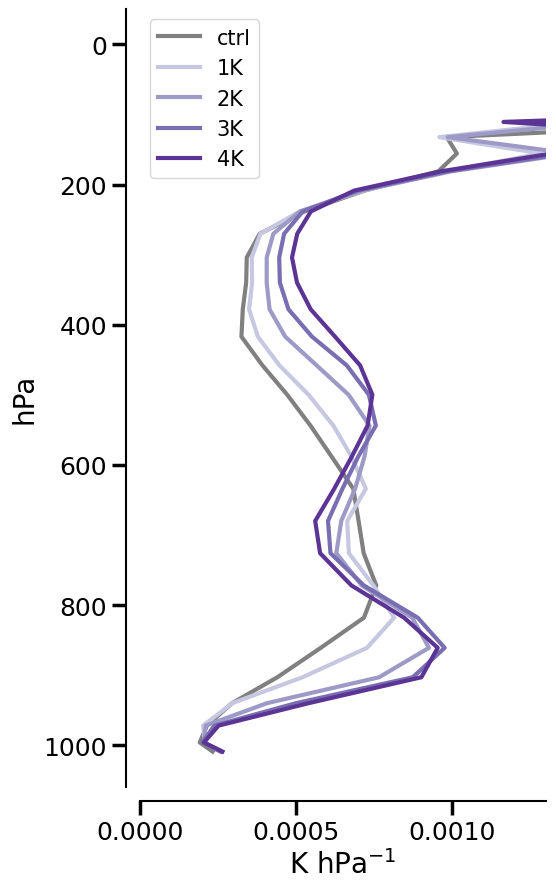

In [37]:
xlabel =  r'K hPa$^{-1}$' #r'T / K'
#xlabel = r'$Q_{rad}$ / K day$^{-1}$'
ylabel = 'hPa'
xlim = [0, 0.0013]

fig,ax = plt.subplots(figsize=(6,9))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    

for key, var in congestus.items():
    
    var_name = congestus[key]['stability']['dT/dp']
    color = congestus[key]['stability']['color']
    
    ax.plot(var_name, var_name.plev/100, color = color, label = key, linewidth = 3)        

ax.xaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
ax.set_xlim(xlim)
plt.xlabel(xlabel, size=20)
plt.ylabel(ylabel, size=20)
plt.legend( title_fontsize=15, fontsize=15)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('Figures/stability_changes.pdf')

In [17]:
cm = plt.cm.Reds(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):

    q_rad = variable_rad['1/16']['dtdt_rheat_lw'] + variable_rad['1/16']['dtdt_rheat_sw']
    cloud_heating = variable_rad['1/16']['dtdt_cloud'] 
    con_heating = variable_rad['1/16']['dtdt_cucall']
    st = variable_ATM['1/16']['st']
    tpot = variable_ATM['1/16']['tpot']
    omega = variable_ATM['1/16']['var135'].mean(dim='time')
    
    stability = -(st / tpot) * tpot.differentiate('plev')
    q = -1 * ( q_rad + con_heating + cloud_heating) / (24 * 3600)
    q_subsidence = (q / stability).mean(dim='time')
    
    q_rad = (-1 * q_rad) / (24 * 3600)
    rad_subsidence = ( q_rad / stability).mean(dim='time')
    
    subsidence = bf.subsidence_mask(omega, plev=None)
    
    rad_subsidence = rad_subsidence.where(subsidence, drop=True)
    rad_subsidence = bf.global_mean_weighted(rad_subsidence)

    q_subsidence = q_subsidence.where(subsidence, drop=True)
    q_subsidence = bf.global_mean_weighted(q_subsidence)

    omega_subsidence = omega.where(subsidence, drop=True)
    omega_subsidence = bf.global_mean_weighted(omega_subsidence)

    # Use the correct key for color mapping
    color = color_map.get(key_rad, cm[i+1])
        
    congestus[key_rad]['radiative subsidence'] = {
        'rad_subsidence': rad_subsidence,
        'q_subsidence': q_subsidence,
        'omega_output': omega_subsidence,
        'color': color
    }

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/n

In [21]:
cm = plt.cm.Greens(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):
    
    omega = variable_ATM['1/16']['var135'].mean(dim='time')
    
    subsidence = bf.subsidence_mask(omega, plev=None)
    omega_subsidence = omega.where(subsidence, drop=True)

    omega_subsidence = bf.global_mean_weighted(omega_subsidence)

    # Ensure the key exists in the dictionary

    # Use the correct key for color mapping
    color = color_map.get(key_rad, cm[i+1])
        
    congestus[key_rad]['subsidence'] = {
        'omega': omega_subsidence, 
        'color': color
    }

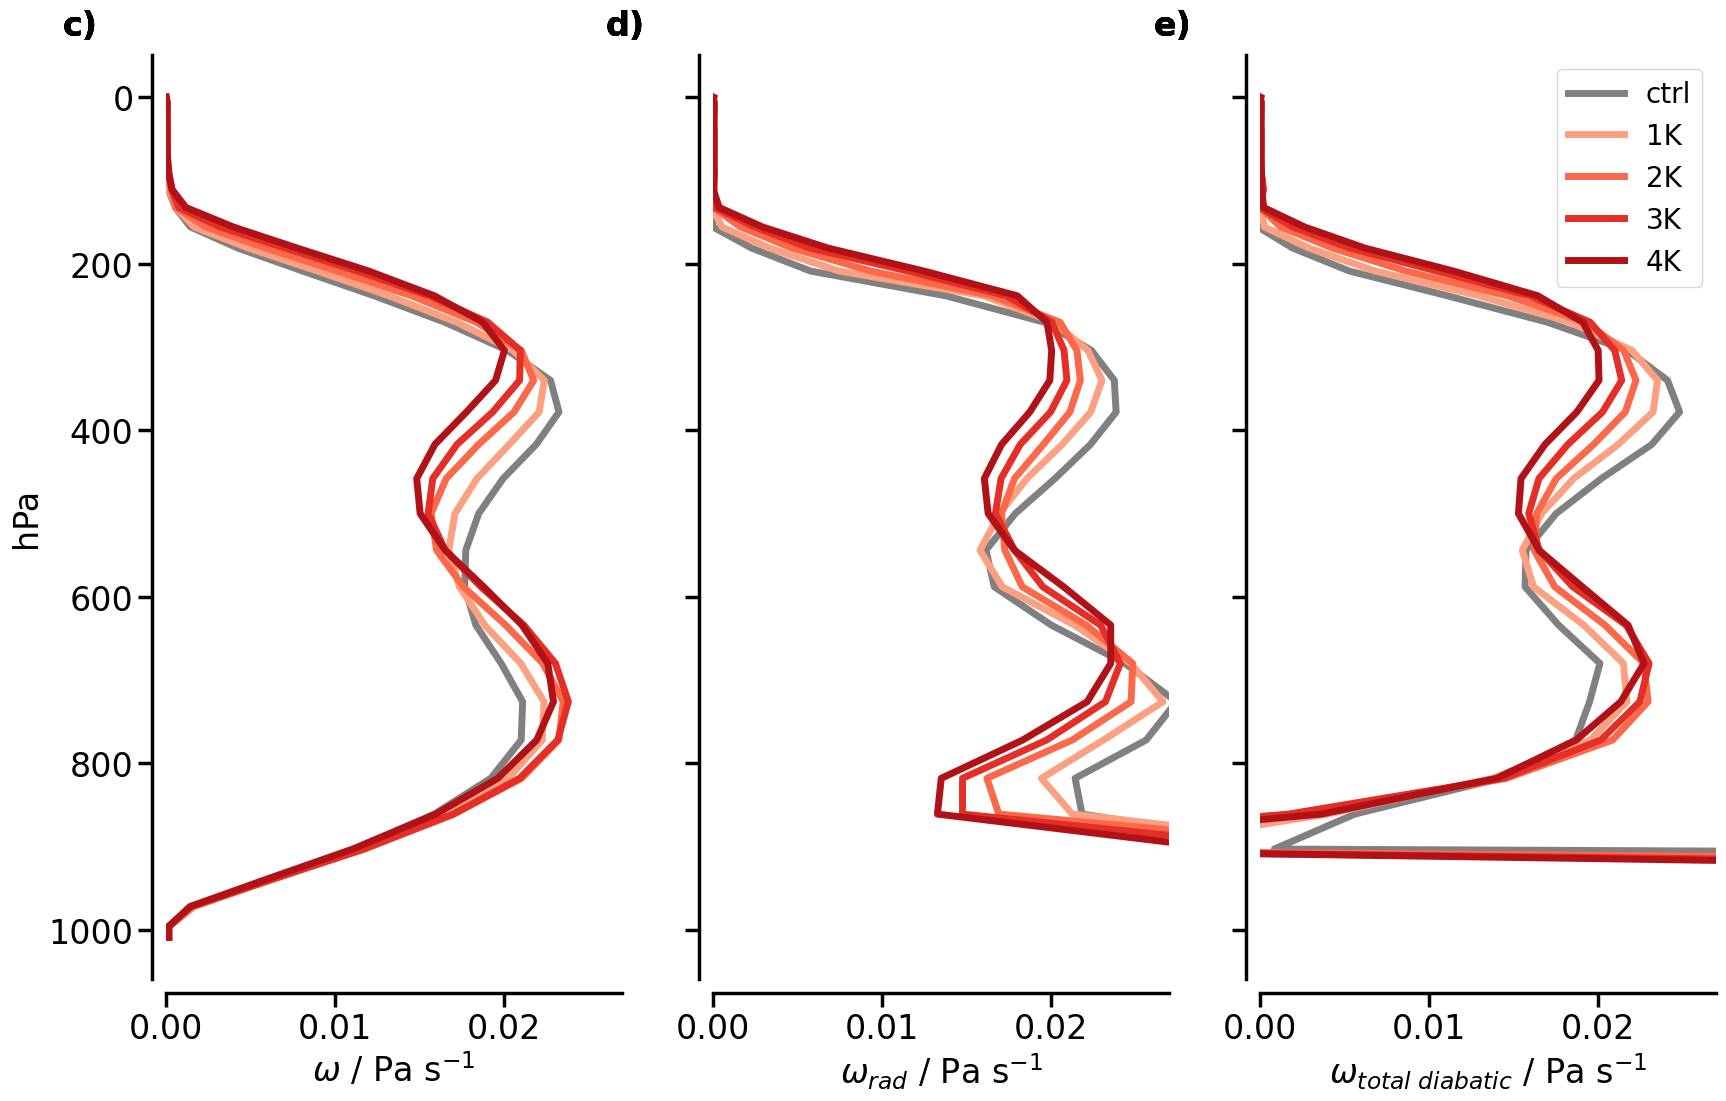

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 12), sharey='row')
axes = axes.ravel()

# Function to configure axes
def configure_axes(ax, xlabel, ylabel=False, xlim=None):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_xlabel(xlabel, fontsize=24)
    ax.xaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    if  ylabel:
        #ax.invert_yaxis()
        ax.set_ylabel('hPa', size=24)
    if xlim:
        ax.set_xlim(xlim)

subplot_labels = ['c)', 'd)', 'e)']
# Iterate over axes
for key, var in congestus.items():
    for i, ax in enumerate(axes):

        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')
        
        if i == 0:
            var_name = var['radiative subsidence']['omega_output']
            color = var['radiative subsidence']['color']
            xlabel = r'$\omega$ / Pa s$^{-1}$'
            xlim = [None, 0.027]
            configure_axes(ax, xlabel,xlim=xlim,ylabel=True)
        elif i == 1:
            var_name = var['radiative subsidence']['rad_subsidence']
            color = var['radiative subsidence']['color']
            xlabel = r'$\omega_{rad}$ / Pa s$^{-1}$'
            xlim = [None, 0.027]
            configure_axes(ax, xlabel, xlim=xlim)
        elif i == 2:
            var_name = var['radiative subsidence']['q_subsidence']
            color = var['radiative subsidence']['color']
            xlabel =  r'$\omega_{total \ diabatic}$ / Pa s$^{-1}$'
            xlim = [None, 0.027]
            configure_axes(ax, xlabel, xlim=xlim)
        
        ax.plot(var_name, var_name.plev / 100, color=color, label=key, linewidth=5)
ax.invert_yaxis()
# Add legends after plotting
axes[2].legend( title_fontsize=20, fontsize=20, loc='upper right')
#axes[2].legend( title_fontsize=20, fontsize=20, loc='center right')
#axes[1].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[2].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[3].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')

plt.savefig('Figures/congestus_change2.pdf')

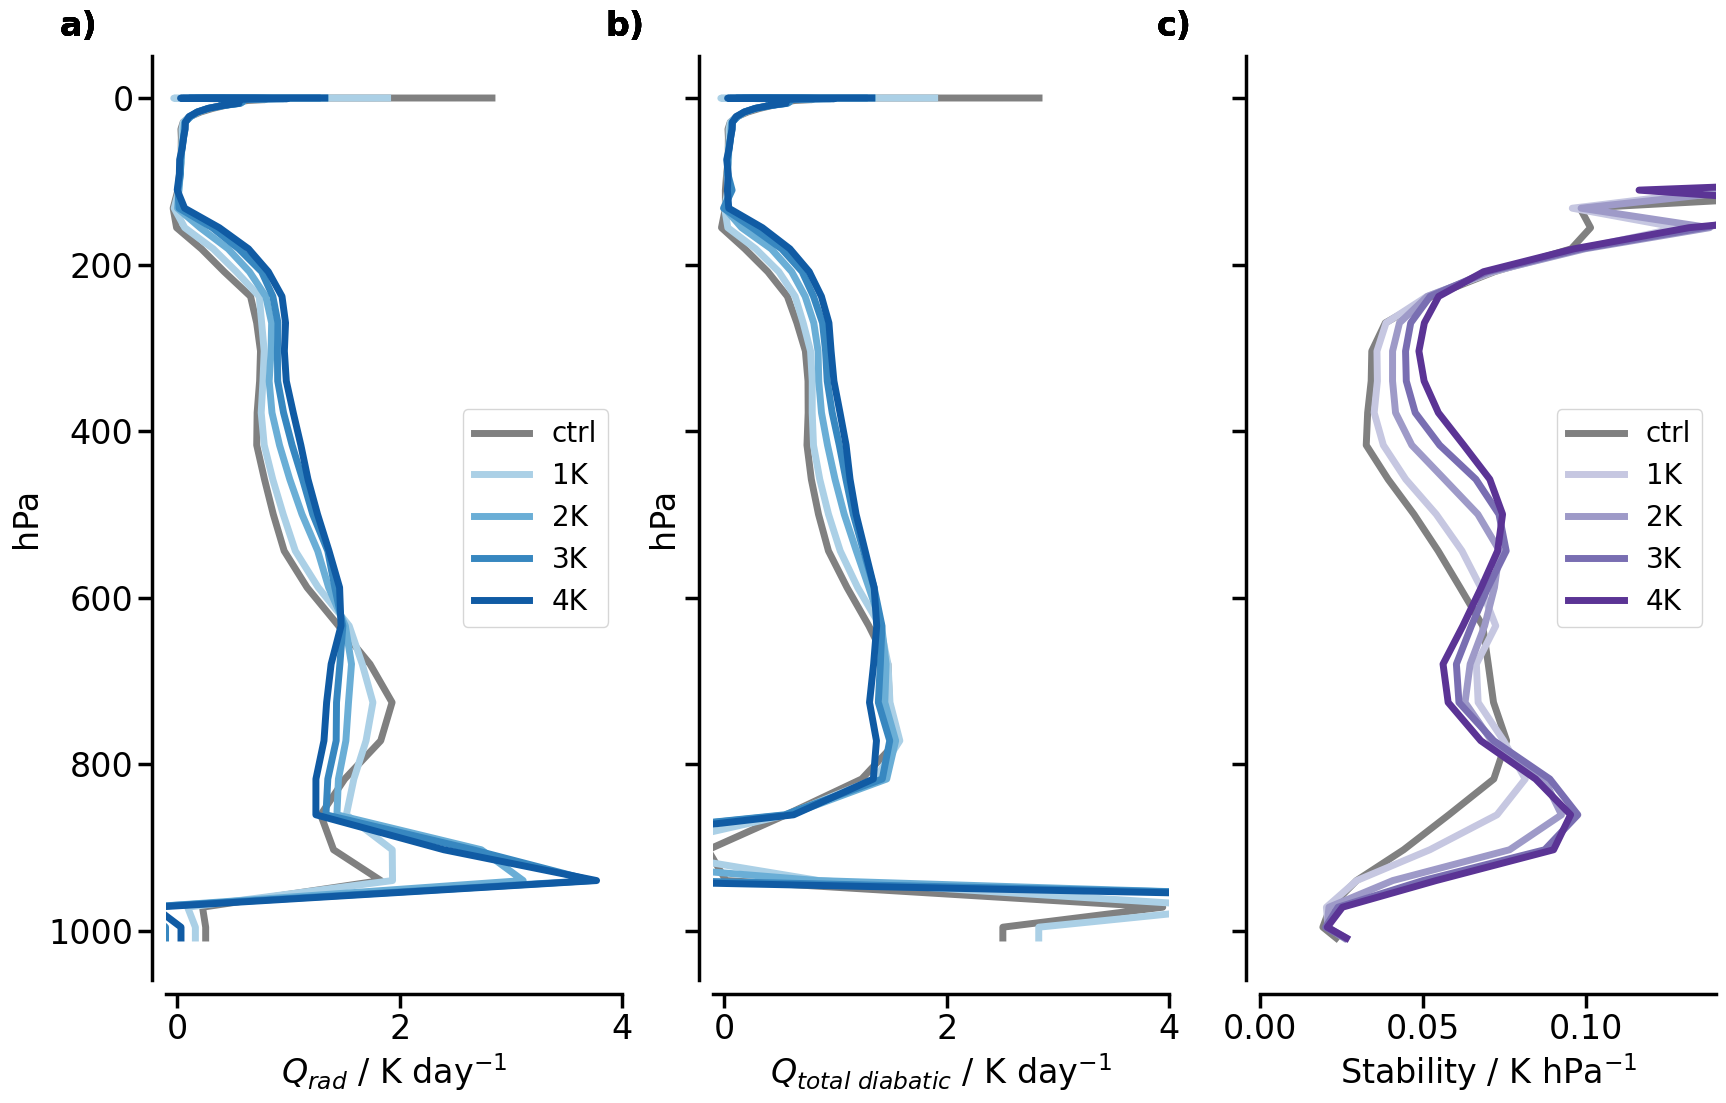

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 12), sharey='row')
axes = axes.ravel()

# Function to configure axes
def configure_axes(ax, xlabel, ylabel=False, xlim=None):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_xlabel(xlabel, fontsize=24)
    ax.xaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    if  ylabel:
        #ax.invert_yaxis()
        ax.set_ylabel('hPa', size=24)
    if xlim:
        ax.set_xlim(xlim)

subplot_labels = ['a)', 'b)', 'c)']
# Iterate over axes
for key, var in congestus.items():
    for i, ax in enumerate(axes):

        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')
        
        if i == 0:
            var_name = -1*var['cooling 1/16']['q_rad']
            color = var['cooling 1/16']['color']
            xlabel = r'$Q_{rad}$ / K day$^{-1}$'
            xlim = [-0.1, 4]
            configure_axes(ax, xlabel,xlim=xlim, ylabel=True)
        if i == 1:
            var_name = var['cooling 1/16']['q']
            color = var['cooling 1/16']['color']
            xlabel = r'$Q_{total \ diabatic}$ / K day$^{-1}$'
            xlim = [-0.1, 4]
            configure_axes(ax, xlabel, xlim=xlim, ylabel=True)
        elif i == 2:
            var_name = var['stability']['dT/dp']
            color = var['stability']['color']
            xlabel =  r'Stability / K hPa$^{-1}$' #r'T / K'
            xlim = [None, 0.14]
            configure_axes(ax, xlabel, xlim=xlim)
        
        ax.plot(var_name, var_name.plev / 100, color=color, label=key, linewidth=5)
ax.invert_yaxis()
# Add legends after plotting
axes[0].legend( title_fontsize=20, fontsize=20, loc='center right')
axes[2].legend( title_fontsize=20, fontsize=20, loc='center right')
#axes[1].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[2].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[3].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')

plt.savefig('Figures/congestus_change.pdf')

# Anvil clouds

In [28]:
congestus = {}
cm = plt.cm.RdPu(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}
time_slice = slice(19860131.996528,20151231.996528)

cloud_ctrl = bf.dict_to_xarray(data_ATM['ctrl'],'aclcac',('rotation', rotation),
                               time_slice)

ice_ctrl = bf.dict_to_xarray(data_ATM['ctrl'],'xi',('rotation', rotation), 
                             time_slice)

for i, (key_ATM, variable_ATM) in enumerate(data_ATM.items()):

    if key_ATM == 'ctrl':
        continue

    cloud = bf.dict_to_xarray(variable_ATM,'aclcac',('rotation', rotation),
                               time_slice)

    ice = bf.dict_to_xarray(variable_ATM,'xi',('rotation', rotation), 
                             time_slice)

    cloud_diff = cloud - cloud_ctrl
    ice_diff = ice - ice_ctrl
    
    cld_zonal_mean = cloud_diff.sel(plev=slice(40000,None)).mean(dim=['time','lon','plev'])
    ice_zonal_mean = ice_diff.sel(plev=slice(40000,None)).mean(dim=['time','lon','plev'])

    if key_ATM not in congestus:
        congestus[key_ATM] = {}

    color = color_map.get(key_ATM, cm[i+1])
        
    congestus[key_ATM]['anvil cloud'] = {
        'cloud_zonal': cld_zonal_mean,
        'ice_zonal': ice_zonal_mean,
        'color': color
    }

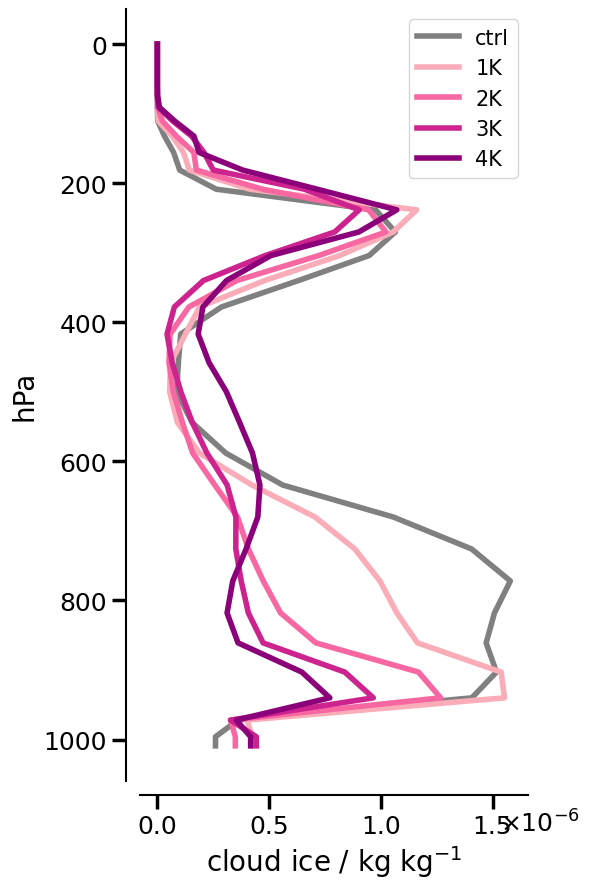

In [46]:
xlabel = r'$\omega_{rad + con + cloud}$ / Pa s$^{-1}$'
xlabel = r'$Q_{rad}$ / K day$^{-1}$'
xlabel = r'cloud ice / kg kg$^{-1}$'
ylabel = 'hPa'
xlim = [0, .03]

fig,ax = plt.subplots(figsize=(6,9))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    

for key, var in congestus.items():
    
    var_name = congestus[key]['anvil cloud']['xi']
    color = congestus[key]['anvil cloud']['color']
    ax.plot(var_name, var_name.plev/100, color = color, label = key, linewidth = 4)        

ax.xaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=18, width=2.5, length=10)
#ax.set_xlim(xlim)
plt.xlabel(xlabel, size=20)
plt.ylabel(ylabel, size=20)
plt.legend( title_fontsize=15, fontsize=15)
ax.invert_yaxis()

ax.xaxis.get_offset_text().set_visible(False)

ax.annotate(r'$\times 10^{-6}$', xy=(1, 0), xytext=(-20,-40),
            xycoords='axes fraction', textcoords='offset points',
            fontsize=18, ha='left', va='bottom')

plt.tight_layout()
plt.savefig('Figures/omeha_changes.pdf')

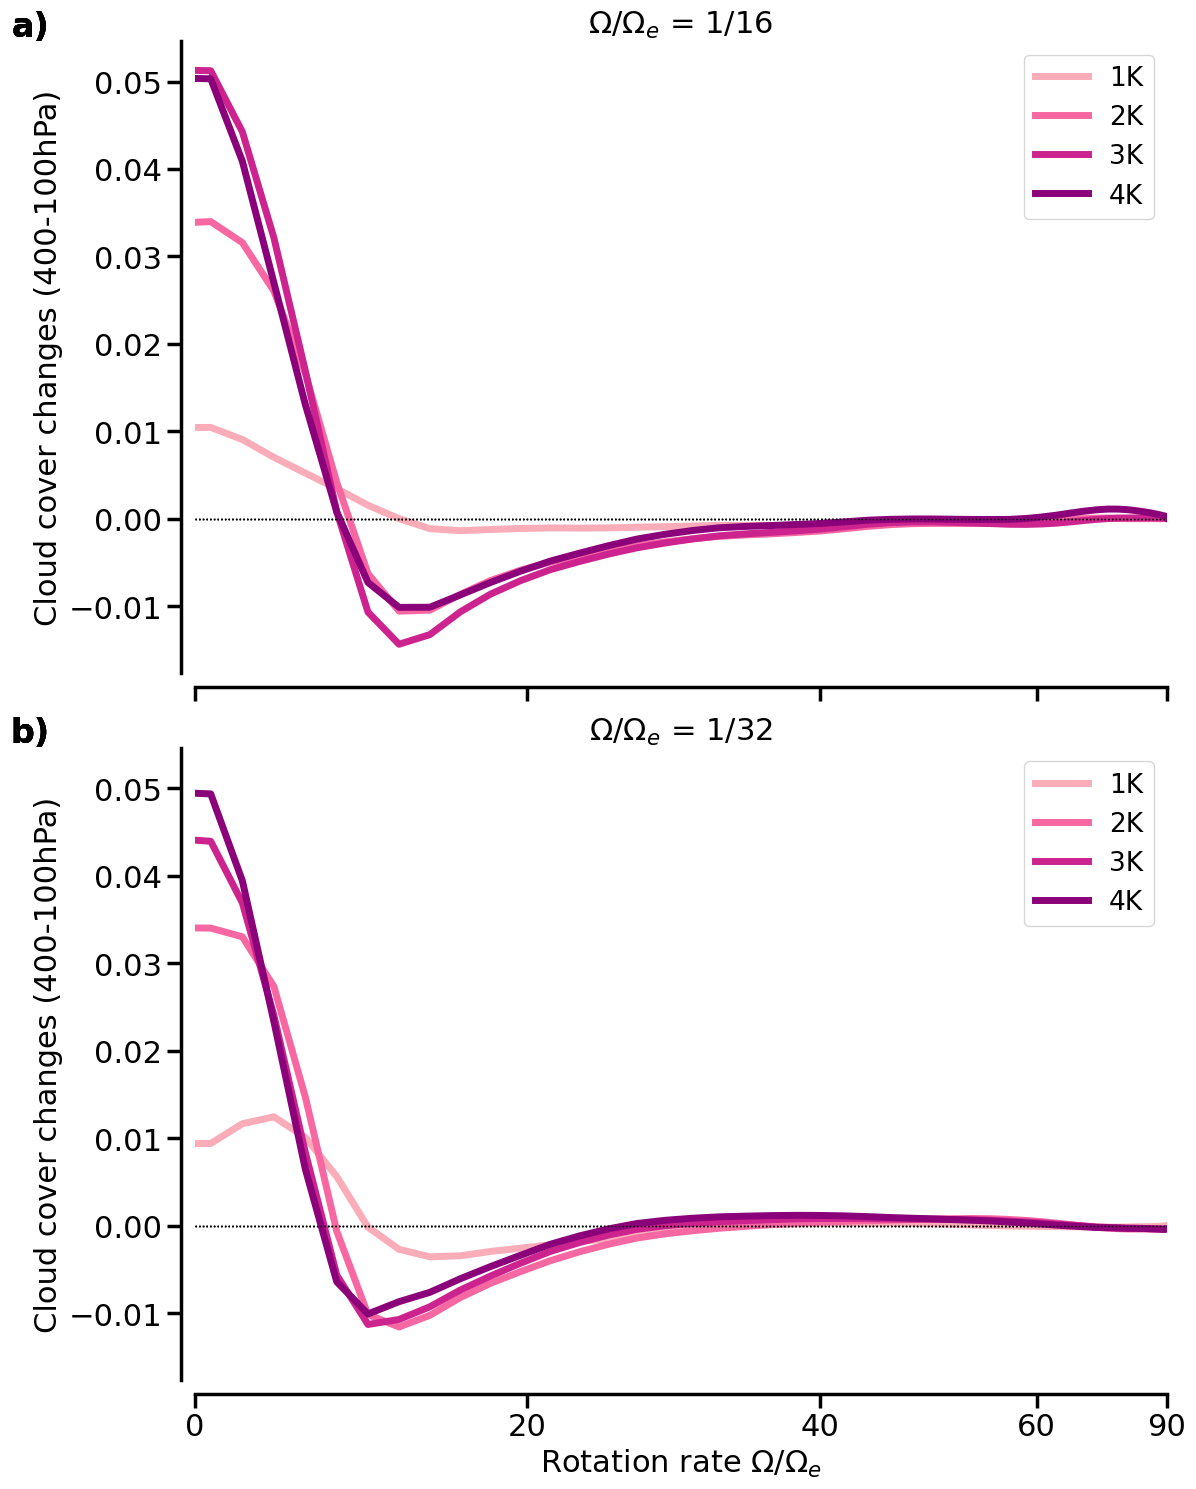

In [31]:
from matplotlib.ticker import ScalarFormatter

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 15), sharex=True, sharey='col')
axes = axes.ravel()

def configure_axes(ax, ylabel, ylim=None, xlabel=False, title=False):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_ylabel(ylabel, fontsize=22)
    ax.xaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    if xlabel:
        ax.set_xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=22)
    if ylim:
        ax.set_ylim(ylim)
    if title:
        ax.set_title(title, size=22)

# Iterate over axes
subplot_labels = ['a)', 'b)', 'c)']

for key, var in congestus.items():
    for i, ax in enumerate(axes):

        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')

        if i == 0:
            var_name = var['anvil cloud']['cloud_zonal'].sel(rotation='1/16')
            color = var['anvil cloud']['color']
            x = np.sin(np.deg2rad(var['anvil cloud']['cloud_zonal'].lat))
            ylabel = 'Cloud cover changes (400-100hPa)'
            configure_axes(ax, ylabel, title=r'$\Omega/\Omega_e$ = 1/16')
        elif i == 1:
            var_name = var['anvil cloud']['cloud_zonal'].sel(rotation='1/32')
            color = var['anvil cloud']['color']
            x = np.sin(np.deg2rad(var['anvil cloud']['cloud_zonal'].lat))
            ylabel = 'Cloud cover changes (400-100hPa)'
            configure_axes(ax, ylabel, xlabel=True, title=r'$\Omega/\Omega_e$ = 1/32')

        ax.plot(x, var_name, color=color, linewidth=5, linestyle='solid', 
            label=key)

        ticks_deg = np.array([-90, -60, -40, -20, 0, 20, 40, 60, 90])
        ax.set_xticks(np.sin(np.deg2rad(ticks_deg)))
        ax.set_xticklabels(ticks_deg)
        ax.set_xlim(0, np.sin(np.deg2rad(90)))
        ax.axhline(y=0, color='k', linewidth=1, linestyle = 'dotted')
        ax.legend(fontsize=19, loc='upper right')

plt.tight_layout()
plt.savefig('Figures/lw_cloud_feedback.pdf')

# Relative humidity

In [15]:
cm = plt.cm.Greens(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)
color_map = {'ctrl': 'grey'}

rh = {}

# Iterate over the data, skipping the 'ctrl' key
for i, (key, variable_ATM) in enumerate(data_ATM.items()):

    # Convert data to xarray
    q = bf.dict_to_xarray(variable_ATM, 'q', ('rotation',rotation), time_slice)
    T = bf.dict_to_xarray(variable_ATM, 'st', ('rotation',rotation), time_slice)

    r_col = rf.column_relative_humidity(q, T, slice(40000, 10000))

    r_col_mean = r_col.mean(dim=['time','lon'])

    if key not in rh:
        rh[key] = {} 

    color = color_map.get(key, cm[i+1])

    # Store the response and associated color
    rh[key]['crh'] = {'mean': r_col_mean,
                      'color': color}

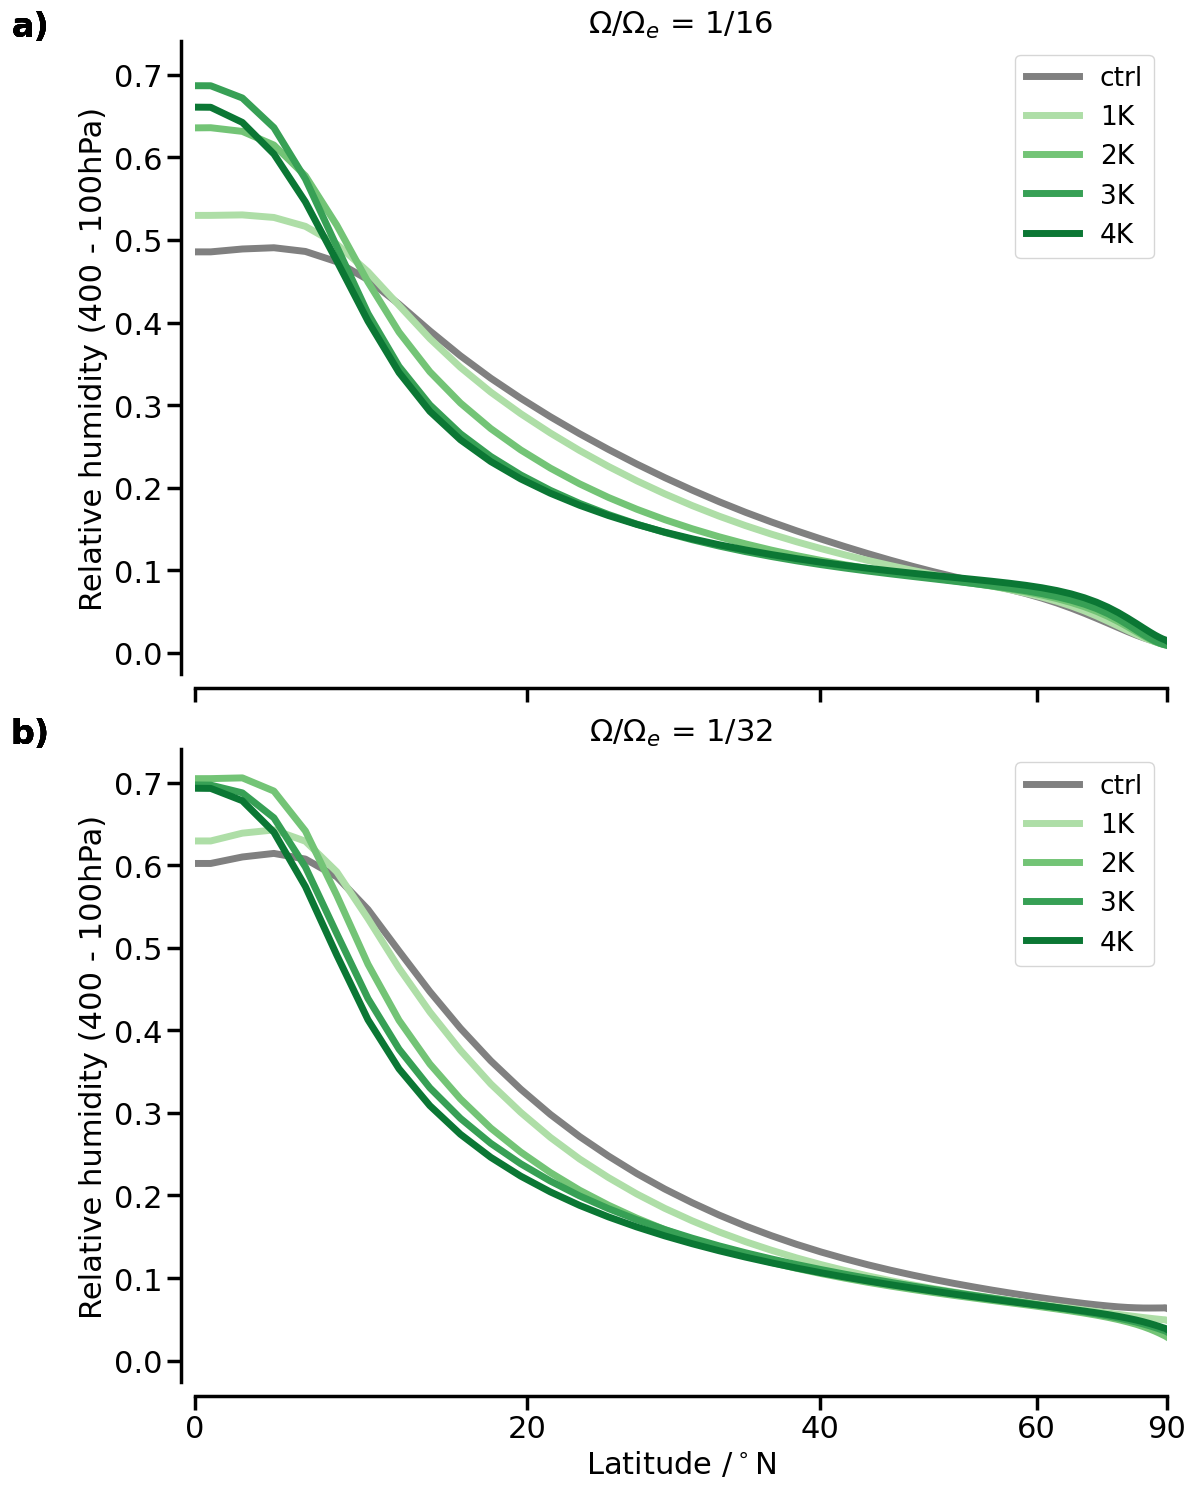

In [16]:
from matplotlib.ticker import ScalarFormatter

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 15), sharex=True, sharey='col')
axes = axes.ravel()

def configure_axes(ax, ylabel, ylim=None, xlabel=False, title=False):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_ylabel(ylabel, fontsize=22)
    ax.xaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=22, width=2.5, length=10)
    if xlabel:
        ax.set_xlabel('Latitude /'r'$^\circ$N', size=22)
    if ylim:
        ax.set_ylim(ylim)
    if title:
        ax.set_title(title, size=22)

# Iterate over axes
subplot_labels = ['a)', 'b)', 'c)']

for key, var in rh.items():
    for i, ax in enumerate(axes):

        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')

        if i == 0:
            var_name = var['crh']['mean'].sel(rotation='1/16')
            color = var['crh']['color']
            x = np.sin(np.deg2rad(var['crh']['mean'].lat))
            ylabel = 'Relative humidity (400 - 100hPa)'
            configure_axes(ax, ylabel, title=r'$\Omega/\Omega_e$ = 1/16')
        elif i == 1:
            var_name = var['crh']['mean'].sel(rotation='1/32')
            color = var['crh']['color']
            x = np.sin(np.deg2rad(var['crh']['mean'].lat))
            ylabel = 'Relative humidity (400 - 100hPa)'
            configure_axes(ax, ylabel, xlabel=True, title=r'$\Omega/\Omega_e$ = 1/32')

        ax.plot(x, var_name, color=color, linewidth=5, linestyle='solid', 
            label=key)

        ticks_deg = np.array([-90, -60, -40, -20, 0, 20, 40, 60, 90])
        ax.set_xticks(np.sin(np.deg2rad(ticks_deg)))
        ax.set_xticklabels(ticks_deg)
        ax.set_xlim(0, np.sin(np.deg2rad(90)))
        #ax.axhline(y=0, color='k', linewidth=1, linestyle = 'dotted')
        ax.legend(fontsize=19, loc='upper right')

plt.tight_layout()
plt.savefig('Figures/crh.pdf')

# Temperature

In [42]:
cm = plt.cm.OrRd(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)
color_map = {'ctrl': 'grey'}

st = {}

# Iterate over the data, skipping the 'ctrl' key
for i, (key, variable_ATM) in enumerate(data_ATM.items()):

    # Convert data to xarray
    T = bf.dict_to_xarray(variable_ATM, 'st', ('rotation',rotation), time_slice)
    omega = bf.dict_to_xarray(variable_ATM, 'var135', ('rotation',rotation), time_slice)
    

    #T = T.mean(dim=['time'])
    #omega = omega.mean(dim='time')
    #subsidence = bf.subsidence_mask(omega, plev=None)
#    T_subsidence = T.where(subsidence, drop=True)

    #T_subsidence = bf.global_mean_weighted(T_subsidence)

    T = T.sel(lat = slice(90,15))
    weights = np.cos(np.radians(T.lat))

    # Normalize weights so they sum to 1
    weights /= weights.sum()

    # Calculate the weighted average temperature
    weighted_average_T = (T * weights).sum(dim='lat')

    T = weighted_average_T.mean(dim=['time','lon'])
    if key not in st:
        st[key] = {} 

    color = color_map.get(key, cm[i+1])

    # Store the response and associated color
    st[key]['temp'] = {'mean': T,
                      'color': color}

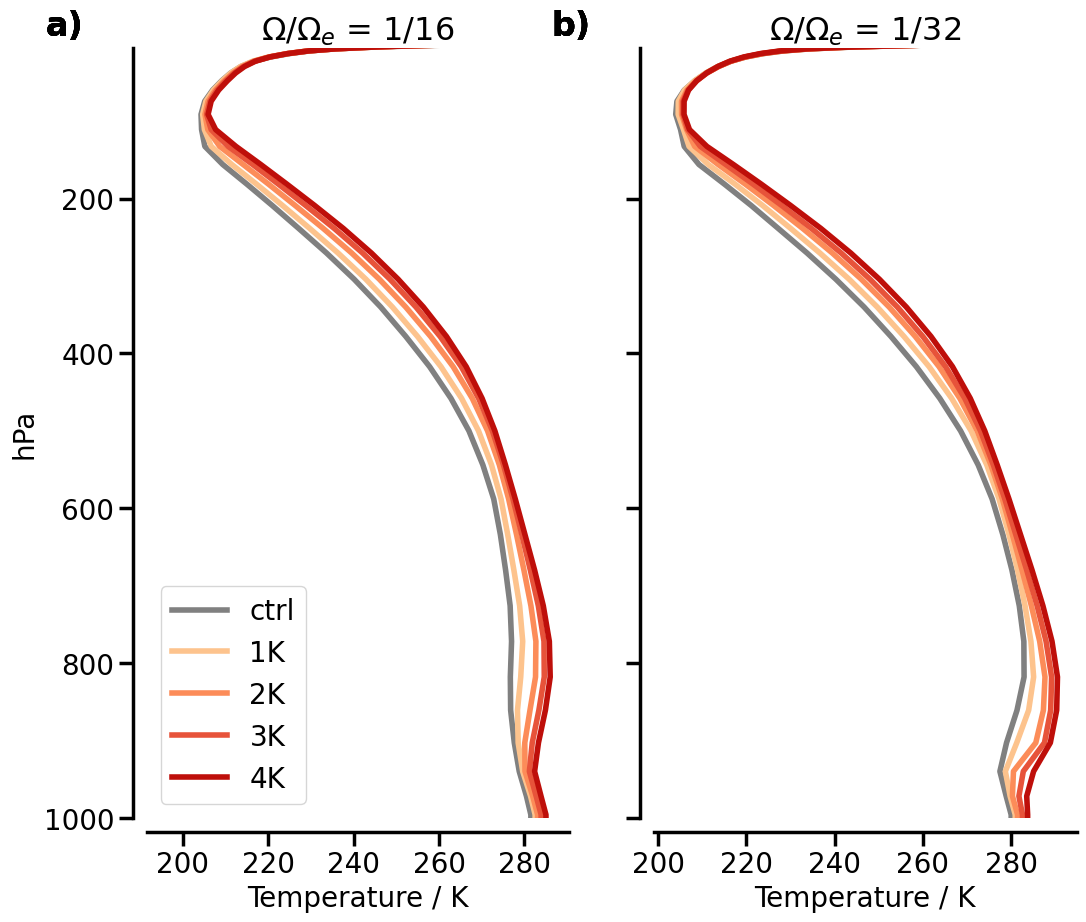

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 10), sharey='row')
axes = axes.ravel()

# Function to configure axes
def configure_axes(ax, xlabel, ylabel=False, xlim=None, title=None):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_xlabel(xlabel, fontsize=20)
    ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
    if  ylabel:
        #ax.invert_yaxis()
        ax.set_ylabel('hPa', size=20)
    if xlim:
        ax.set_xlim(xlim)
    if title:
        ax.set_title(title, size=23)

subplot_labels = ['a)', 'b)', 'c)']

# Iterate over axes
for key, var in st.items():
    for i, ax in enumerate(axes):
        
        ax.text(-0.15, 1.05, subplot_labels[i], transform=ax.transAxes, 
                fontsize=24, fontweight='bold', va='top', ha='right')
        
        if i == 0:
            var_name = var['temp']['mean'].sel(rotation='1/16')
            color = var['temp']['color']
            xlabel = 'Temperature / K'
            xlim = [0, 0.03]
            configure_axes(ax, xlabel,ylabel=True, title=r'$\Omega/\Omega_e$ = 1/16')
        elif i == 1:
            var_name = var['temp']['mean'].sel(rotation='1/32')
            color = var['temp']['color']
            xlabel = 'Temperature / K'
            configure_axes(ax, xlabel, title=r'$\Omega/\Omega_e$ = 1/32')
        
        ax.plot(var_name, var_name.plev / 100, color=color, label=key, linewidth=4)
        
ax.invert_yaxis()
ax.set_ylim(1000,5)
# Add legends after plotting
axes[0].legend( title_fontsize=20, fontsize=20, loc='lower left')
#axes[1].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[2].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')
#axes[3].legend(title=r'   $\Omega/\Omega_{e}$', title_fontsize=20, fontsize=20, loc='upper right')

plt.savefig('Figures/temp.pdf')

# Radiative divergence

In [16]:
time_slice = slice(19860131.996528,20151231.996528)
cm = plt.cm.Purples(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

deep = {}
for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):

    tpot = bf.dict_to_xarray(variable_ATM, 'tpot', ('rotation', rotation), time_slice)  
    q_rad = bf.dict_to_xarray(variable_rad, 'dtdt_rheat_lw', ('rotation', rotation), time_slice)    
    q_rad = q_rad * -1
    st = bf.dict_to_xarray(variable_ATM, 'st', ('rotation', rotation), time_slice)
    omega = bf.dict_to_xarray(variable_ATM, 'var135', ('rotation', rotation), time_slice)
    omega = omega.mean(dim='time')
    
    stability = -(st / tpot) * tpot.differentiate('plev')
    rad_subsidence = (q_rad / stability).mean(dim='time')

    subsidence = bf.subsidence_mask(omega, plev=None)
    rad_subsidence = rad_subsidence.where(subsidence, drop=True)
    rad_divergence = rad_subsidence.sel(plev=slice(70000, 10000)).differentiate('plev')
    rad_divergence = bf.global_mean_weighted(rad_divergence).max(dim='plev')

    color = color_map.get(key_rad, cm[i + 1])
    deep[key_rad] = {'rad div': rad_divergence, 'color': color}

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/n

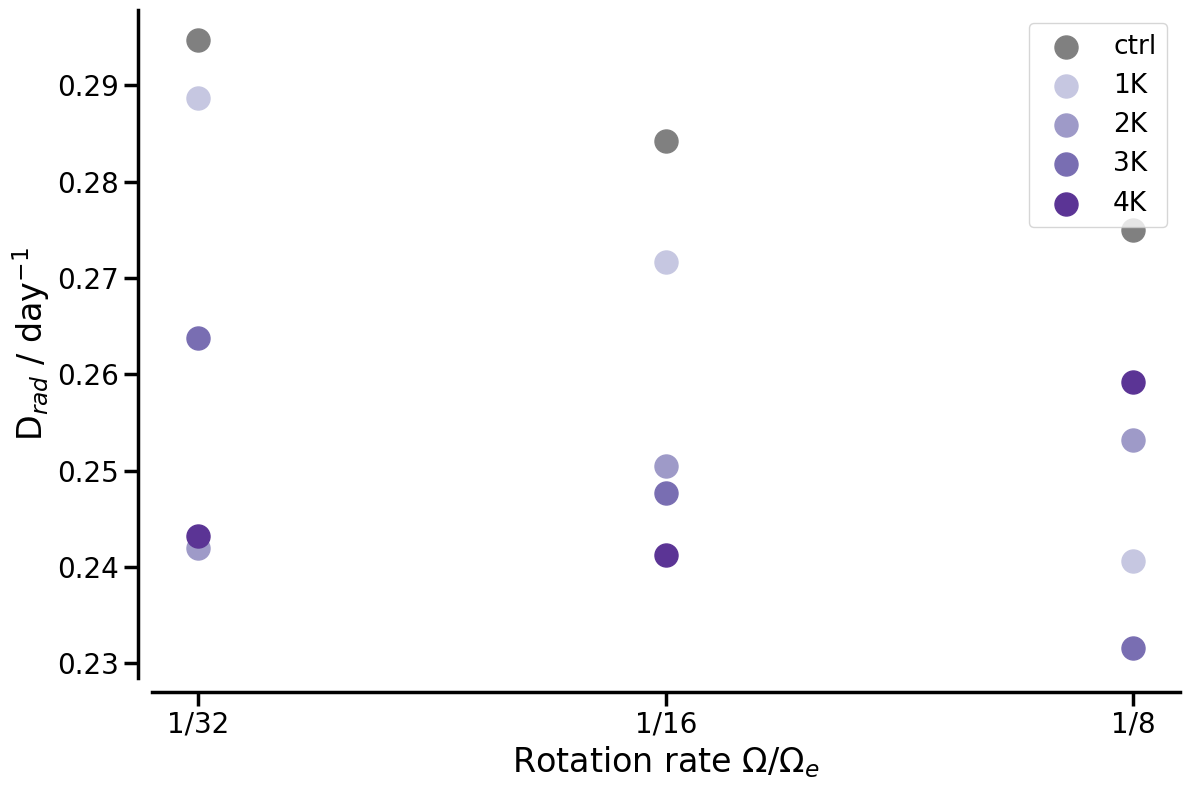

In [17]:
ylabel = 'D$_{rad}$ / day$^{-1}$'
y_lim = [0, 0.4]

fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    
ticks = rotation
x = np.arange(0, len(ticks))


for key, var in deep.items():
    y = var['rad div']
    color = var['color']
    ax.scatter(x, y, color = color, label = key, 
            marker = 'o', s = 275)
    
ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.xaxis.set_ticks(x)
ax.set_xticklabels([x for x in ticks])


plt.xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=24)
plt.ylabel(ylabel, size=24)
plt.legend(fontsize=19)

plt.tight_layout()
plt.savefig('Figures/lts.pdf')

In [18]:
time_slice = slice(19860131.996528,20151231.996528)
cm = plt.cm.Greens(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

relhum = {}
for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):

    rh = bf.dict_to_xarray(variable_ATM, 'relhum', ('rotation', rotation), time_slice)
    omega = bf.dict_to_xarray(variable_ATM, 'var135', ('rotation', rotation), time_slice)
    omega = omega.mean(dim='time')

    subsidence = bf.subsidence_mask(omega, plev=None)
    
    rh_subsidence = rh.where(subsidence, drop=True)
    rh_subsidence = rh_subsidence.sel(plev=slice(70000, 10000)).differentiate('plev')
    rh_subsidence = bf.global_mean_weighted(rh_subsidence)

    color = color_map.get(key_rad, cm[i + 1])
    relhum[key_rad] = {'relhum': rh_subsidence, 'color': color}

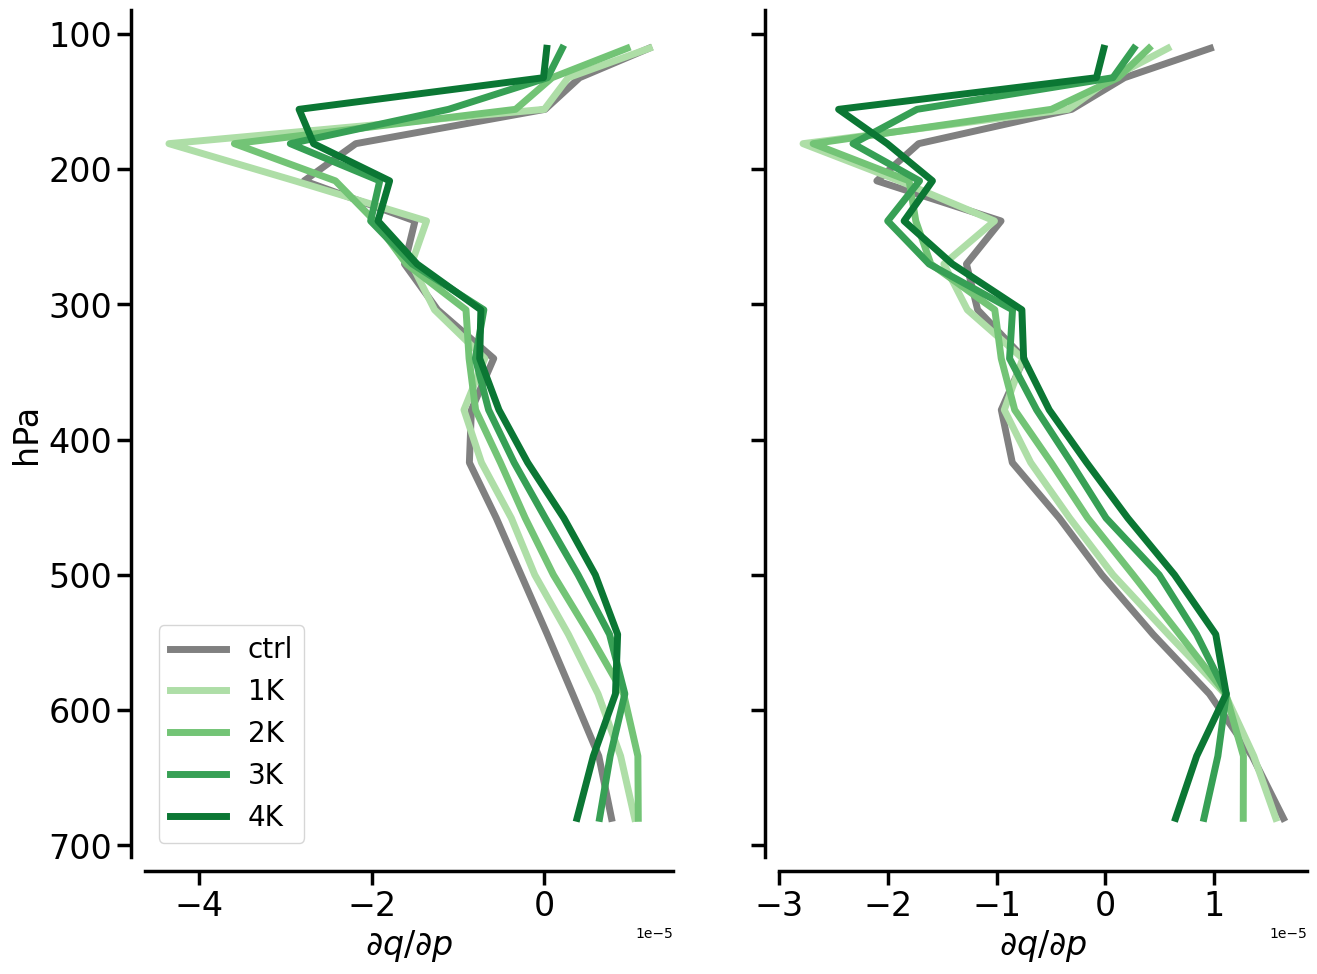

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 11), sharey='row')
axes = axes.ravel()

# Function to configure axes
def configure_axes(ax, xlabel, invert_y=False, xlim=None):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_xlabel(xlabel, fontsize=24)
    ax.xaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    if invert_y:
        ax.invert_yaxis()
        ax.set_ylabel('hPa', size=24)
    if xlim:
        ax.set_xlim(xlim)

# Iterate over axes
for key, var in relhum.items():
    for i, ax in enumerate(axes):
        if i == 0:
            var_name = var['relhum'].sel(rotation='1/32')
            color = var['color']
            #xlabel = r'$\partial \mathcal{R}/ \partial p$'
            xlabel = r'$\partial q/ \partial p$'
            configure_axes(ax, xlabel, invert_y=True)
        elif i == 1:
            var_name = var['relhum'].sel(rotation='1/16')
            color = var['color']
            xlabel = r'$\partial q/ \partial p$'
            configure_axes(ax, xlabel)
        
        ax.plot(var_name, var_name.plev / 100, color=color, label=key, linewidth=5)

# Add legends after plotting
axes[0].legend(fontsize=20, loc='lower left')
#axes[1].legend( fontsize=20, loc='center left')

plt.savefig('Figures/Rad_div.pdf')

In [19]:
time_slice = slice(19860131.996528,20151231.996528)
cm = plt.cm.Blues(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

cooling_rate = {}
for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):

    q_rad = bf.dict_to_xarray(variable_rad, 'dtdt_rheat_lw', ('rotation', rotation), time_slice)
    omega = bf.dict_to_xarray(variable_ATM, 'var135', ('rotation', rotation), time_slice)
    omega = omega.mean(dim='time')

    subsidence = bf.subsidence_mask(omega, plev=None)
    
    q_rad_subsidence = q_rad.where(subsidence, drop=True) * -1
    q_rad_subsidence = q_rad_subsidence.sel(plev=slice(70000, 10000)).differentiate('plev')
    q_rad_subsidence = bf.global_mean_weighted(q_rad_subsidence)

    color = color_map.get(key_rad, cm[i + 1])
    cooling_rate[key_rad] = {'q_rad': q_rad_subsidence, 'color': color}

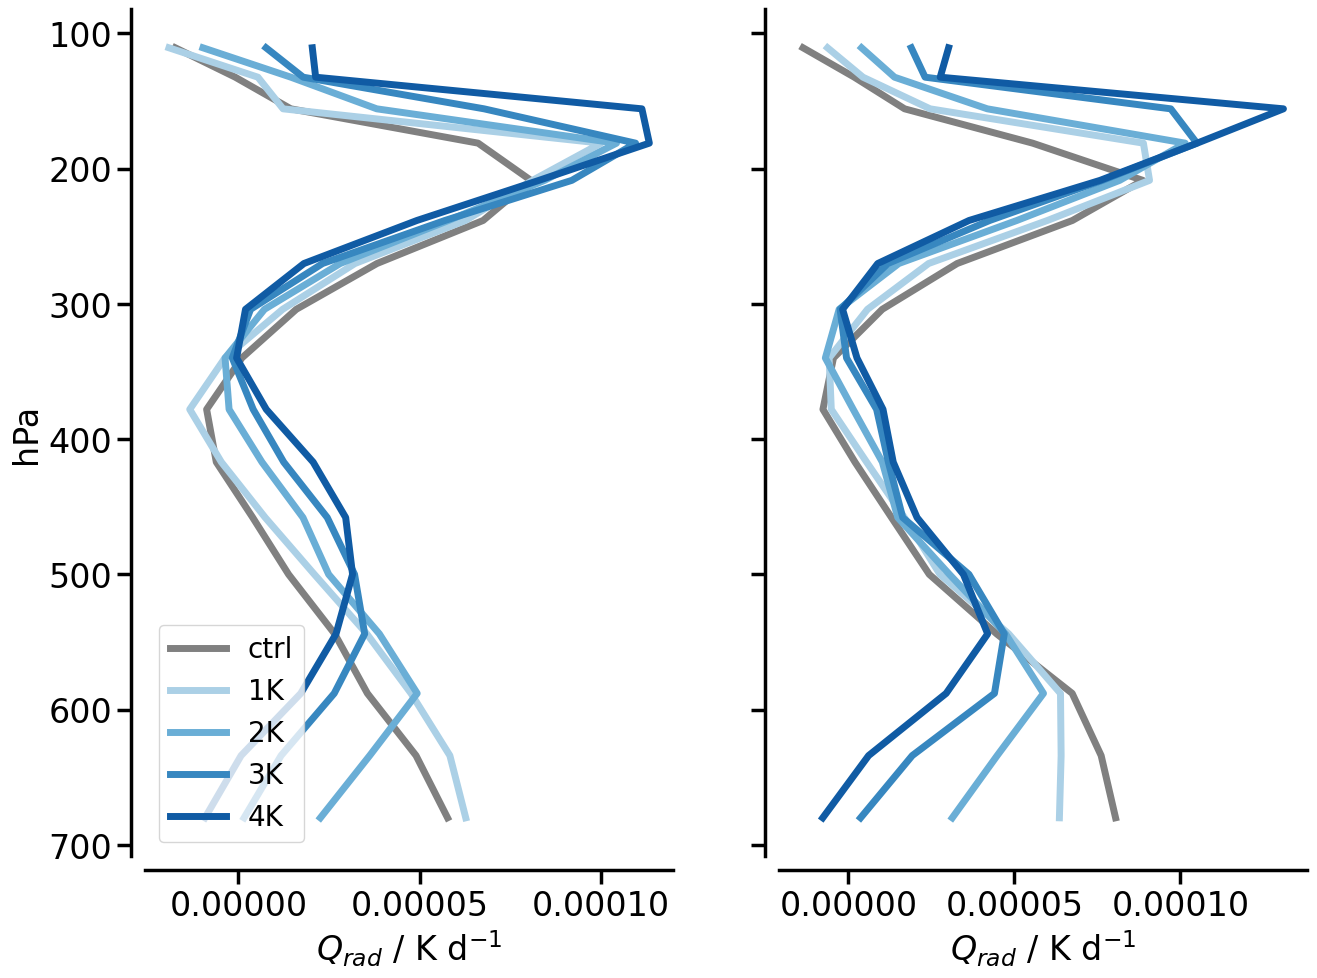

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 11), sharey='row')
axes = axes.ravel()

# Function to configure axes
def configure_axes(ax, xlabel, invert_y=False, xlim=None):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_xlabel(xlabel, fontsize=24)
    ax.xaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    if invert_y:
        ax.invert_yaxis()
        ax.set_ylabel('hPa', size=24)
    if xlim:
        ax.set_xlim(xlim)

# Iterate over axes
for key, var in cooling_rate.items():
    for i, ax in enumerate(axes):
        if i == 0:
            var_name = var['q_rad'].sel(rotation='1/32')
            color = var['color']
            xlabel = r'$Q_{rad}$ / K d$^{-1}$'
            configure_axes(ax, xlabel, invert_y=True)
        elif i == 1:
            var_name = var['q_rad'].sel(rotation='1/16')
            color = var['color']
            xlabel = r'$Q_{rad}$ / K d$^{-1}$'
            configure_axes(ax, xlabel)
        
        ax.plot(var_name, var_name.plev / 100, color=color, label=key, linewidth=5)

# Add legends after plotting
axes[0].legend(fontsize=20, loc='lower left')
#axes[1].legend( fontsize=20, loc='center left')

plt.savefig('Figures/Rad_div.pdf')

# Variance CRH

In [19]:
colormap = plt.cm.OrRd(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528, 20151231.996528)

hadley_extent = {}

# Iterate over both data_ATM and data_mastrfu
for i, (key, data) in enumerate(data_mastrfu.items()):
    
    mastrfu = bf.dict_to_xarray(data, 'mastrfu', ('rotation', rotation), time_slice)

    mastrfu_north = mastrfu.mean(dim=['time', 'lon']).sel(lat=slice(90, 5))

    latitude = fun.hadley_cell_extent(mastrfu_north, 30000, 70000)

    # Determine color
    if key == 'ctrl':
        color = 'grey'
    else:
        color = colormap[i+1]

    # Store results
    hadley_extent[key] = {
        'latitude': latitude,
        'color': color
    }

In [21]:
cm = plt.cm.OrRd(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)
color_map = {'ctrl': 'grey'}

crh_var = {}

# Iterate over the data, skipping the 'ctrl' key
for i, ((key, data),(key_h, hadley)) in enumerate(zip(data_ATM.items(), hadley_extent.items())):

    # Convert data to xarray
    q = bf.dict_to_xarray(data, 'q', ('rotation',rotation), time_slice)
    T = bf.dict_to_xarray(data, 'st', ('rotation',rotation), time_slice)

    lat = hadley['latitude']

    r_col = rf.column_relative_humidity(q, T, slice(40000, 10000))

    aggregation = rf.crh_binning(r_col, lat)

    if key not in crh_var:
        crh_var[key] = {} 

    color = color_map.get(key, cm[i+1])

    # Store the response and associated color
    crh_var[key]['crh'] = {'var': aggregation,
                      'color': color}

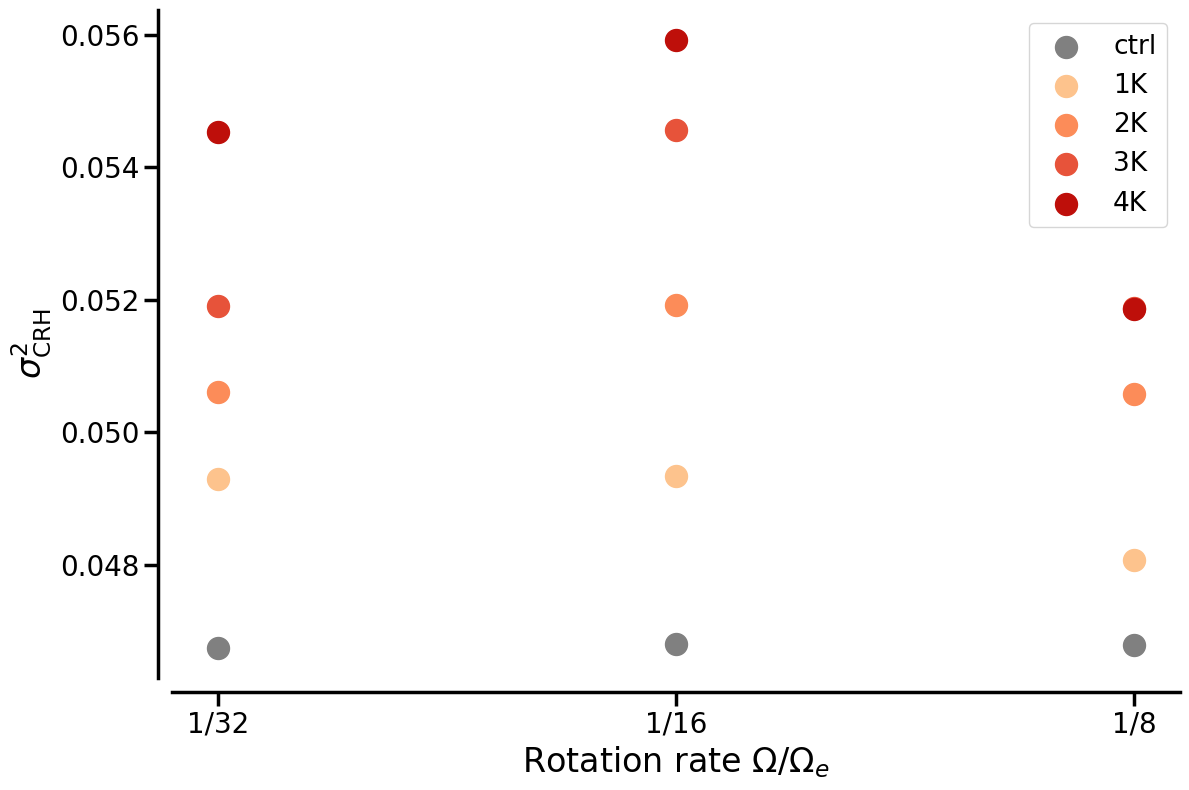

In [22]:
ylabel = ylabel = r'$\sigma^2_{\mathrm{CRH}}$'
y_lim=[25,90]


fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
    
ticks = ['1/32','1/16','1/8']#,'1/4']# ,'1/2' , '1']
x = np.arange(0, len(ticks))

for key, var in crh_var.items():
    y = var['crh']['var'].var(dim='bins')
    ax.scatter(x, y, color = var['crh']['color'], label = key, 
            marker = 'o', s = 250)
        

ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.xaxis.set_ticks(x)
ax.set_xticklabels([x for x in ticks])
#ax.set_ylim(y_lim[0],y_lim[1])


plt.xlabel('Rotation rate '+ r'$\Omega/\Omega_{e}$', size=24)
plt.ylabel(ylabel, size=24)
plt.legend(fontsize=19)

plt.tight_layout()
plt.savefig('Figures/aggregation.pdf')

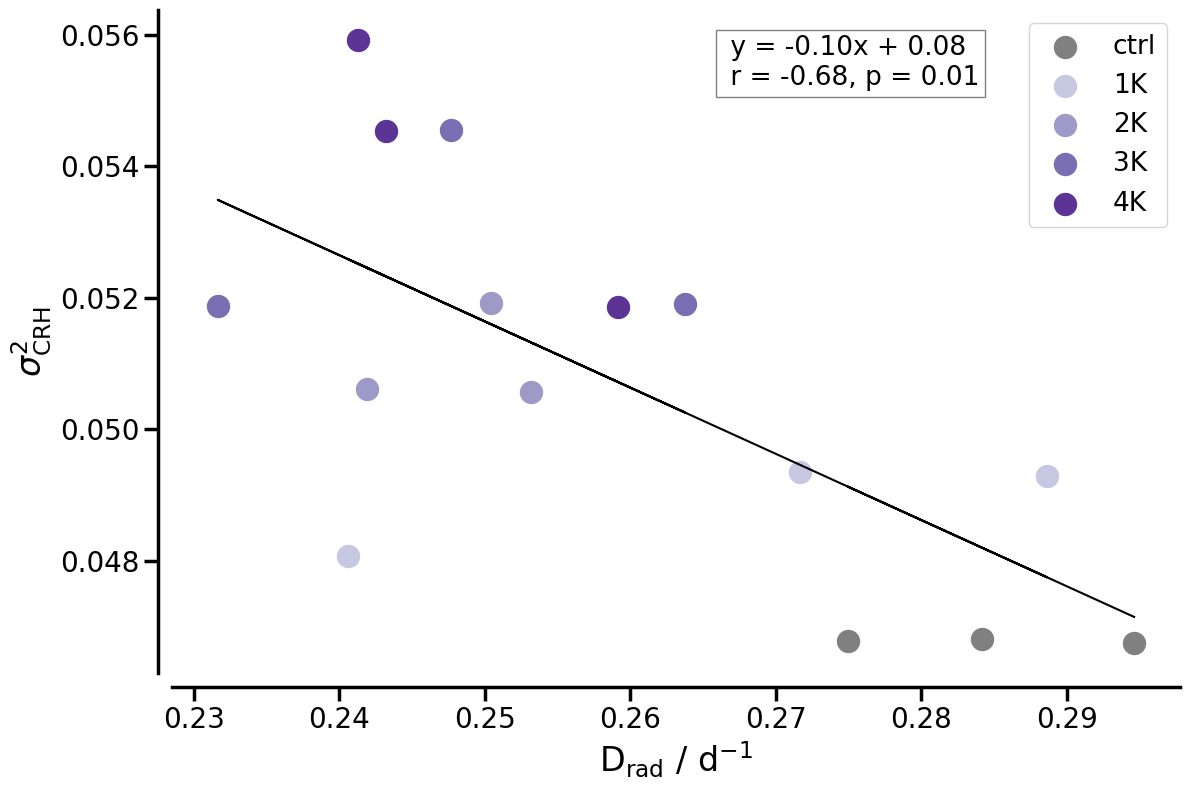

In [52]:
from scipy.stats import pearsonr

ylabel = ylabel = r'$\sigma^2_{\mathrm{CRH}}$'
y_lim=[25,90]


fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))

divergence = []
crh_variance = []
for (key1, var1),(key2, var2) in zip(crh_var.items(), deep.items()):
    x = var2['rad div']
    y = var1['crh']['var'].var(dim='bins')
    divergence.append(x.values)
    crh_variance.append(y.values)
    ax.scatter(x, y, color = var2['color'], label=key1,
            marker = 'o', s = 250)

x = np.ravel(divergence)
y = np.ravel(crh_variance)

r, p_value = pearsonr(x, y)

slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept

ax.plot(x, line, color='k')
# Calculate position for the text box based on data range
x_text = np.min(x) + (np.max(x) - np.min(x)) * 0.55
y_text = np.min(y) + (np.max(y) - np.min(y)) * 0.925

# Add a legend with detailed information
plt.text(x_text, y_text, f' y = {slope:.2f}x + {intercept:.2f}\n r = {r:.2f}, p = {p_value:.2f}', 
         fontsize=19, bbox=dict(facecolor='white', alpha=0.5))
        

ax.xaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
ax.yaxis.set_tick_params(which='major', labelsize=20, width=2.5, length=10)
#ax.xaxis.set_ticks(x)
#ax.set_xticklabels([x for x in ticks])
#ax.set_ylim(y_lim[0],y_lim[1])


plt.xlabel('D$_\mathrm{rad}$ / d$^{-1}$', size=24)
plt.ylabel(ylabel, size=24)
plt.legend(fontsize=19, loc='upper right')

plt.tight_layout()
plt.savefig('Figures/div_crh.pdf')

# Temperature space

In [208]:
time_slice = slice(19860131.996528,20151231.996528)
cm = plt.cm.Greens(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

relhum = {}
for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):

    rh = bf.dict_to_xarray(variable_ATM, 'relhum', ('rotation', rotation), time_slice)
    temp = bf.dict_to_xarray(variable_ATM, 'st', ('rotation', rotation), time_slice)
    omega = bf.dict_to_xarray(variable_ATM, 'var135', ('rotation', rotation), time_slice)
    omega = omega.mean(dim='time')

    subsidence = bf.subsidence_mask(omega, plev=None)
    
    temp = temp.sel(lat = 0, method='nearest').sel(plev = slice(70000, 10000)
                                                  ).mean(dim=['time','lon'])
    
    rh_subsidence = rh.where(subsidence, drop=True)
    rh_subsidence = rh_subsidence.sel(plev=slice(70000, 10000))#.differentiate('plev')
    rh_subsidence = bf.area_mean_weighted(rh_subsidence, lat_slice=slice(30,10))

    color = color_map.get(key_rad, cm[i + 1])
    relhum[key_rad] = {'relhum': rh_subsidence, 
                       'temp': temp,
                       'color': color}

In [211]:
time_slice = slice(19860131.996528,20151231.996528)
cm = plt.cm.Greens(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

cloud = {}
for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):

    cl = bf.dict_to_xarray(variable_ATM, 'aclcac', ('rotation', rotation), time_slice)
    temp = bf.dict_to_xarray(variable_ATM, 'st', ('rotation', rotation), time_slice)

    temp = temp.sel(lat = 0, method='nearest').sel(plev = slice(70000, 10000)
                                                  ).mean(dim=['time','lon'])
    cl = cl.sel(lat = 0, method='nearest').sel(plev = slice(70000, 10000)
                                                  ).mean(dim=['time','lon'])

    color = color_map.get(key_rad, cm[i + 1])
    cloud[key_rad] = {'cl': cl, 
                   'temp': temp,
                   'color': color}

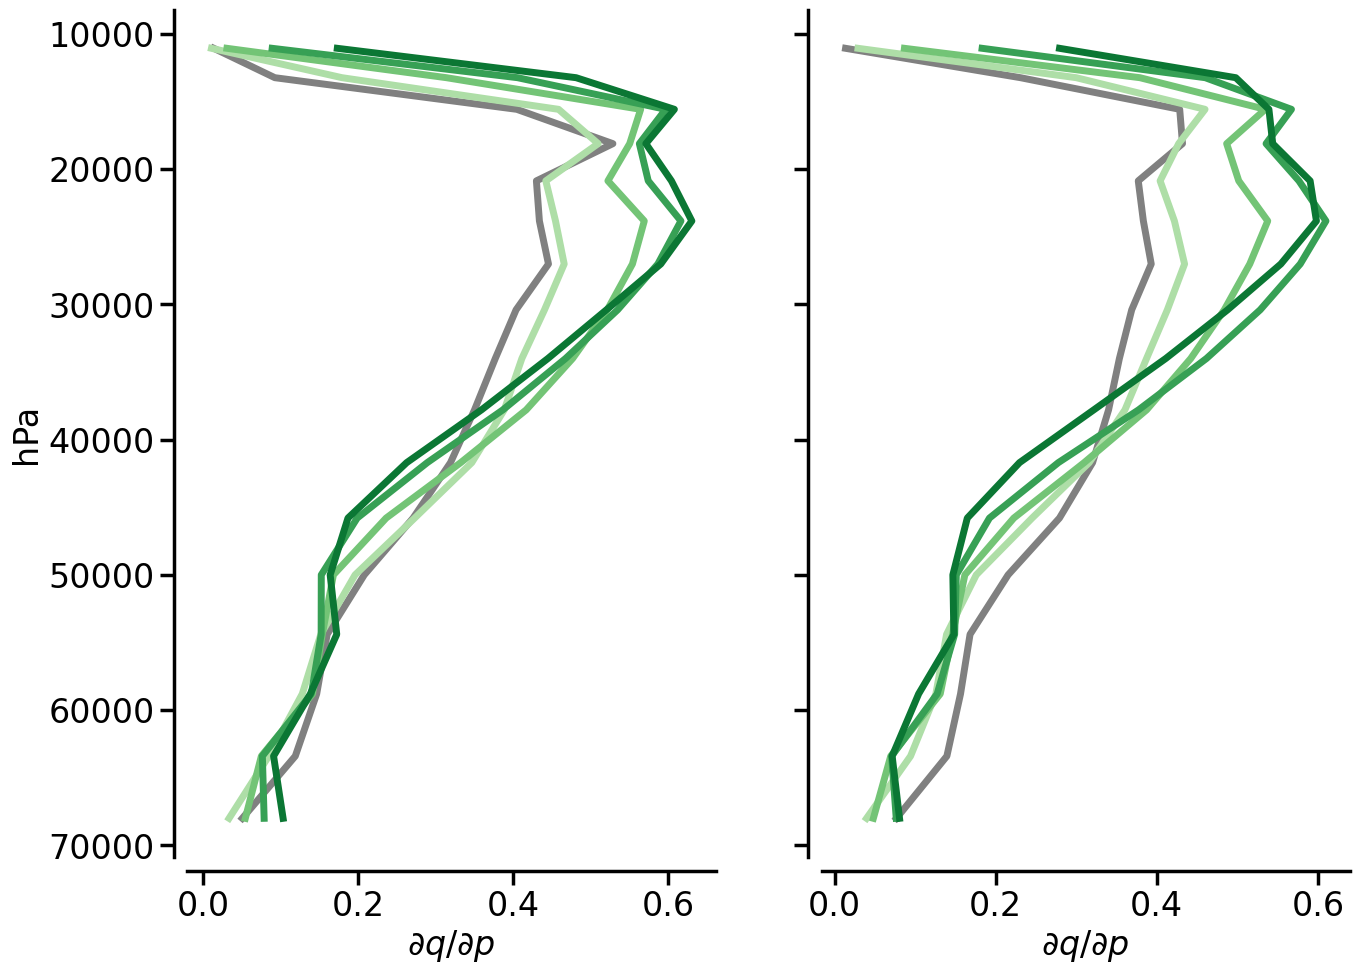

In [215]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 11), sharey='row')
axes = axes.ravel()

# Function to configure axes
def configure_axes(ax, xlabel, invert_y=False, xlim=None):
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines.left.set_position(('outward', 10))
    ax.spines.bottom.set_position(('outward', 10))
    ax.set_xlabel(xlabel, fontsize=24)
    ax.xaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    ax.yaxis.set_tick_params(which='major', labelsize=24, width=2.5, length=10)
    if invert_y:
        ax.invert_yaxis()
        ax.set_ylabel('hPa', size=24)
    if xlim:
        ax.set_xlim(xlim)

# Iterate over axes
for key, var in cloud.items():
    for i, ax in enumerate(axes):
        if i == 0:
            y = var['cl'].sel(rotation='1/32')#.mean(dim=['time','lon'])
            x = var['cl'].sel(rotation='1/32').plev
            color = var['color']
            #xlabel = r'$\partial \mathcal{R}/ \partial p$'
            xlabel = r'$\partial q/ \partial p$'
            configure_axes(ax, xlabel, invert_y=True)
        elif i == 1:
            y = var['cl'].sel(rotation='1/16')#.mean(dim=['time','lon'])
            x = var['cl'].sel(rotation='1/32').plev
            color = var['color']
            xlabel = r'$\partial q/ \partial p$'
            configure_axes(ax, xlabel)
        
        ax.plot(y,x, color=color, label=key, linewidth=5)

# Add legends after plotting
#axes[0].legend(fontsize=20, loc='upper right')
#axes[1].legend( fontsize=20, loc='center left')

plt.savefig('Figures/Rad_div.pdf')

In [20]:
time_slice = slice(19860131.996528,20151231.996528)
cm = plt.cm.Greens(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

relhum = {}
for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):

    rh = bf.dict_to_xarray(variable_ATM, 'relhum', ('rotation', rotation), time_slice)
    temp = bf.dict_to_xarray(variable_ATM, 'st', ('rotation', rotation), time_slice)
    
    temp = temp.sel(lat = 0, method='nearest'
                   ).sel(plev = slice(70000, 10000)
                        ).mean(dim=['time','lon'])
    rh = rh.mean(dim=['time','lon']).sel(plev=slice(30000, 20000))
    rh = rh.differentiate('lat')
    #rh = bf.area_mean_weighted(rh, lat_slice = slice(30,10))

    color = color_map.get(key_rad, cm[i + 1])
    relhum[key_rad] = {'relhum': rh, 
                       'temp:': temp,
                       'color': color}

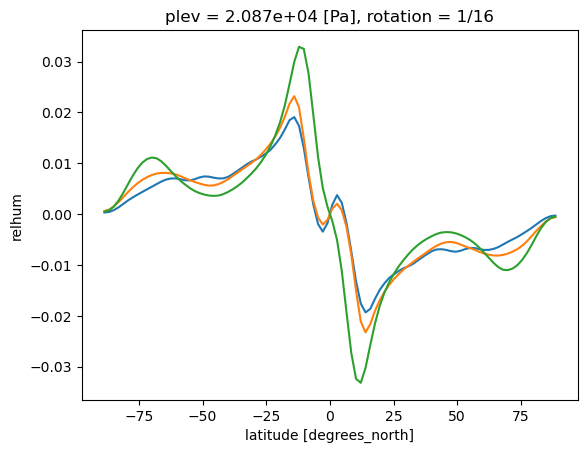

In [37]:
relhum['ctrl']['relhum'].sel(rotation='1/16').sel(plev=30000, method='nearest').plot()
relhum['1K']['relhum'].sel(rotation='1/16').sel(plev=25000, method='nearest').plot()
relhum['4K']['relhum'].sel(rotation='1/16').sel(plev=20000, method='nearest').plot()

In [32]:
cm = plt.cm.Greens(np.linspace(0, 1, 7))
color_map = {'ctrl': 'grey'}

for i, ((key_rad, variable_rad), (key_ATM, variable_ATM)) in enumerate(zip(data_rad.items(), data_ATM.items())):

    q_rad = variable_rad['1/32']['dtdt_rheat_lw'] 
    q_rad = (q_rad) * -1
    st = variable_ATM['1/32']['st']
    tpot = variable_ATM['1/32']['tpot']
    omega = variable_ATM['1/32']['var135'].mean(dim='time')
    
    stability = -(st / tpot) * tpot.differentiate('plev')
    q_rad = q_rad 
    
    rad_w = (q_rad / stability).mean(dim='time')
    
    subsidence = bf.subsidence_mask(omega, plev=None)
    rad_w = rad_w.where(subsidence, drop=True)

    rad_div = rad_w.sel(plev = slice(70000, 10000)
                                       ).differentiate('plev')

    rad_w = bf.global_mean_weighted(rad_w)

    rad_div = bf.global_mean_weighted(rad_div)

    temp = st.sel(lat = 0, method='nearest'
                   ).sel(plev = slice(70000, 10000)
                        ).mean(dim=['time','lon'])

    # Use the correct key for color mapping
    color = color_map.get(key_rad, cm[i+1])
        
    congestus[key_rad]['radiative subsidence'] = {
        'q_rad/stability': rad_w,
        'rad div': rad_div,
        'temp': temp,
        'color': color
    }

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


NameError: name 'congestus' is not defined

# RH vs low cloud

In [62]:
cm = plt.cm.OrRd(np.linspace(0, 1, 7))
time_slice = slice(19860131.996528,20151231.996528)
color_map = {'ctrl': 'grey'}

low_cloud_vs_rh = {}
# Iterate over the data, skipping the 'ctrl' key
for i, (key, variable_ATM) in enumerate(data_ATM.items()):

    # Convert data to xarray
    T = variable_ATM['1/32']['st'].mean(dim='time')
    rh = variable_ATM['1/32']['relhum'].mean(dim='time')
    omega = variable_ATM['1/32']['var135'].mean(dim='time')

    subsidence = bf.subsidence_mask(omega, plev=None)
    rh_subsidence = rh.where(subsidence, drop=True)
    
    T_eq = T.sel(lat=0, method='nearest').mean(dim='lon')
    closest_index = np.abs(T_eq - 273).argmin(dim='plev')
    freezing_level = T_eq['plev'][closest_index]
    #pressure_level = fun.find_nearest_plev(T_eq, 273)

    rh_max = rh_subsidence.mean(dim='lon').sel(plev = slice(80000, 
                                                            pressure_level.item()
                                                           )).max(dim='lat')
    rh_subsidence = bf.global_mean_weighted(rh_subsidence)  
    if key not in low_cloud_vs_rh:
        low_cloud_vs_rh[key] = {}

    color = color_map.get(key, cm[i+1])

    # Store the response and associated color
    low_cloud_vs_rh[key]['rh_max'] = {'mean': rh_subsidence,
                      'color': color}

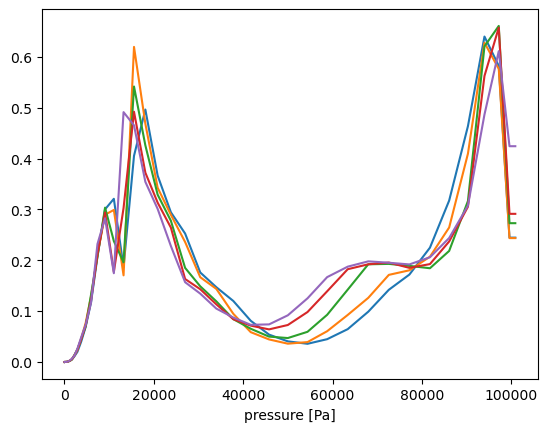

In [63]:
low_cloud_vs_rh['ctrl']['rh_max']['mean'].plot()
low_cloud_vs_rh['1K']['rh_max']['mean'].plot()
low_cloud_vs_rh['2K']['rh_max']['mean'].plot()
low_cloud_vs_rh['3K']['rh_max']['mean'].plot()
low_cloud_vs_rh['4K']['rh_max']['mean'].plot()